<large>
<b>Purpose & Evaluation Plan — HAI Forecasting</b>

This notebook forecasts the <b>Housing Adequacy Index (HAI)</b> by province using the prepared dataset
<code>data/housing_adequacy_dataset.csv</code>. We compare two setups:

1) <b>RAW</b>: use unsmoothed features and predict the raw HAI target.  
2) <b>SMOOTHED</b>: use smoothed features and predict a smoothed HAI target.

<b>Motivation.</b> HAI can be spiky (small denominators, bursts in starts). Smoothing may improve short-horizon
generalization but risks lag/attenuation. We run both paths and compare performance.

<b>Flow.</b>
• Imports, reproducibility, and paths  
• Utility functions (<code>02_func_hai.py</code>)  
• Horizon selection: <code>next_quarter</code> (H=1) vs <code>same_quarter_next_year</code> (H=4)  
• RAW experiment (no smoothing)  
• SMOOTHED experiment (median window = 4)  
• Cache paths for tuned params are shown for provenance and reuse
</large>


<large>
<b>Environment & Reproducibility</b>

Load core libraries and set plotting defaults. Suppress noisy warnings for cleaner output.
Fix random seeds for reproducible tuning and evaluation across runs.
</large>


In [19]:
# ===============================
# Imports & Global Config
# ===============================
import os, json, math, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140
sns.set_context("notebook")


<large>
<b>Data & Split Configuration</b>

• <code>DATA_PATH</code> points to the quarterly dataset with columns including
<code>quarter</code>, <code>province</code>, <code>hai</code>, <code>dwelling_starts</code>, <code>pop_change_q</code>, <code>needed_units_q</code>.  
• <code>CUTOFF_DATE</code> defines a chronological holdout: train ≤ cutoff, test > cutoff.  
• <code>ALL_MODELS</code> enumerates candidate estimators used in both RAW and SMOOTHED runs.
</large>


In [20]:

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Paths
DATA_PATH  = "data/housing_adequacy_dataset.csv"  # must contain: quarter, province, hai, dwelling_starts, pop_change_q, needed_units_q

# Holdout split
CUTOFF_DATE = "2018-12-31"  # train ≤ cutoff, test > cutoff

# Models to try
ALL_MODELS = ["lr", "rf", "ridge", "xgb", "etr"]


<large>
<b>Utilities</b>

Load HAI-specific helpers from <code>utilities/02_func_hai.py</code>.  
Expected responsibilities (encapsulated inside <code>run_hai_experiment</code>):

• Build features/targets for the chosen horizon (H=1 or H=4)  
• Optionally create smoothed features/targets (window=<code>smooth_window</code>, func=<code>smooth_func</code>)  
• Chronological train/test split at <code>cutoff</code>  
• Per-province model tuning (cache-aware), fitting, and prediction  
• Rolling evaluation over multiple cutoffs (<code>initial_roll</code>, <code>roll_step</code>, <code>roll_last_k</code>)  
• Aggregation and packaging of results, metrics tables, and cache path
</large>


In [21]:
%run utilities/02_func_hai.py

<large>
<b>Horizon Selection</b>

Choose the forecasting horizon via <code>PREDICTION_CHOICE</code>:
• <b>next_quarter</b> → H=1 (t+1)  
• <b>same_quarter_next_year</b> → H=4 (t+4, same quarter next year)

The horizon controls lag structure and target alignment inside <code>run_hai_experiment</code>.
</large>


## For "same_quarter_next_year" (H=4)

In [22]:
# Horizon choice: "next_quarter" (H=1) or "same_quarter_next_year" (H=4)
PREDICTION_CHOICE = "same_quarter_next_year"

<large>
<b>Two Parallel Experiments</b>

We execute two otherwise identical pipelines to examine the effect of smoothing on HAI:

1) <b>RAW</b>: <i>use_smooth_features=False</i>, <i>predict_smooth_target=False</i>  
2) <b>SMOOTHED</b>: <i>use_smooth_features=True</i>, <i>predict_smooth_target=True</i>

Both runs share: models, cutoff, rolling config, and tuning budget.
</large>


In [23]:

# ===============================
# Execute RAW & SMOOTHED runs
# ===============================

# Horizon from global PREDICTION_CHOICE
H_RUN = PREDICTION_CHOICE


<large>
<b>Experiment A — RAW Input</b>

No smoothing applied to features or target.  
This establishes a baseline on the original (potentially spiky) HAI series.
Key parameters:
• <code>prediction_choice</code> = H from the global setting  
• <code>smooth_window</code> and <code>smooth_func</code> are ignored for features/target here  
• <code>n_iter_tune</code> is a lightweight tuning budget (increase for deeper search)  
• Rolling evaluation uses <code>initial_roll</code>, <code>roll_step</code>, and <code>roll_last_k</code>
</large>



=== CONFIG ===
Mode=same_quarter_next_year | H=4 | season=4
Smooth: window=4, func=median, featS=False, targetSm=False
Features: ['hai_raw_lag4', 'hai_raw_lag8', 'dwelling_starts_lag4', 'pop_change_q_lag4', 'needed_units_q_lag4']
Holdout: Train 1992-01-01 → 2018-10-01 | Test 2019-01-01 → 2025-07-01
🔁 Loading cached best parameters from best_params_cache_hai_h4_s4_median_featN_tRaw.json

=== HAI — Holdout averages across provinces (tuned) ===


MAE   RMSE   sMAPE   MASE
model                             
etr    1.004  1.267  75.472  1.365
lr     1.088  1.416  89.977  1.471
ridge  1.122  1.447  94.866  1.607
rf     1.136  1.396  79.571  1.411
xgb    1.212  1.510  86.175  1.565

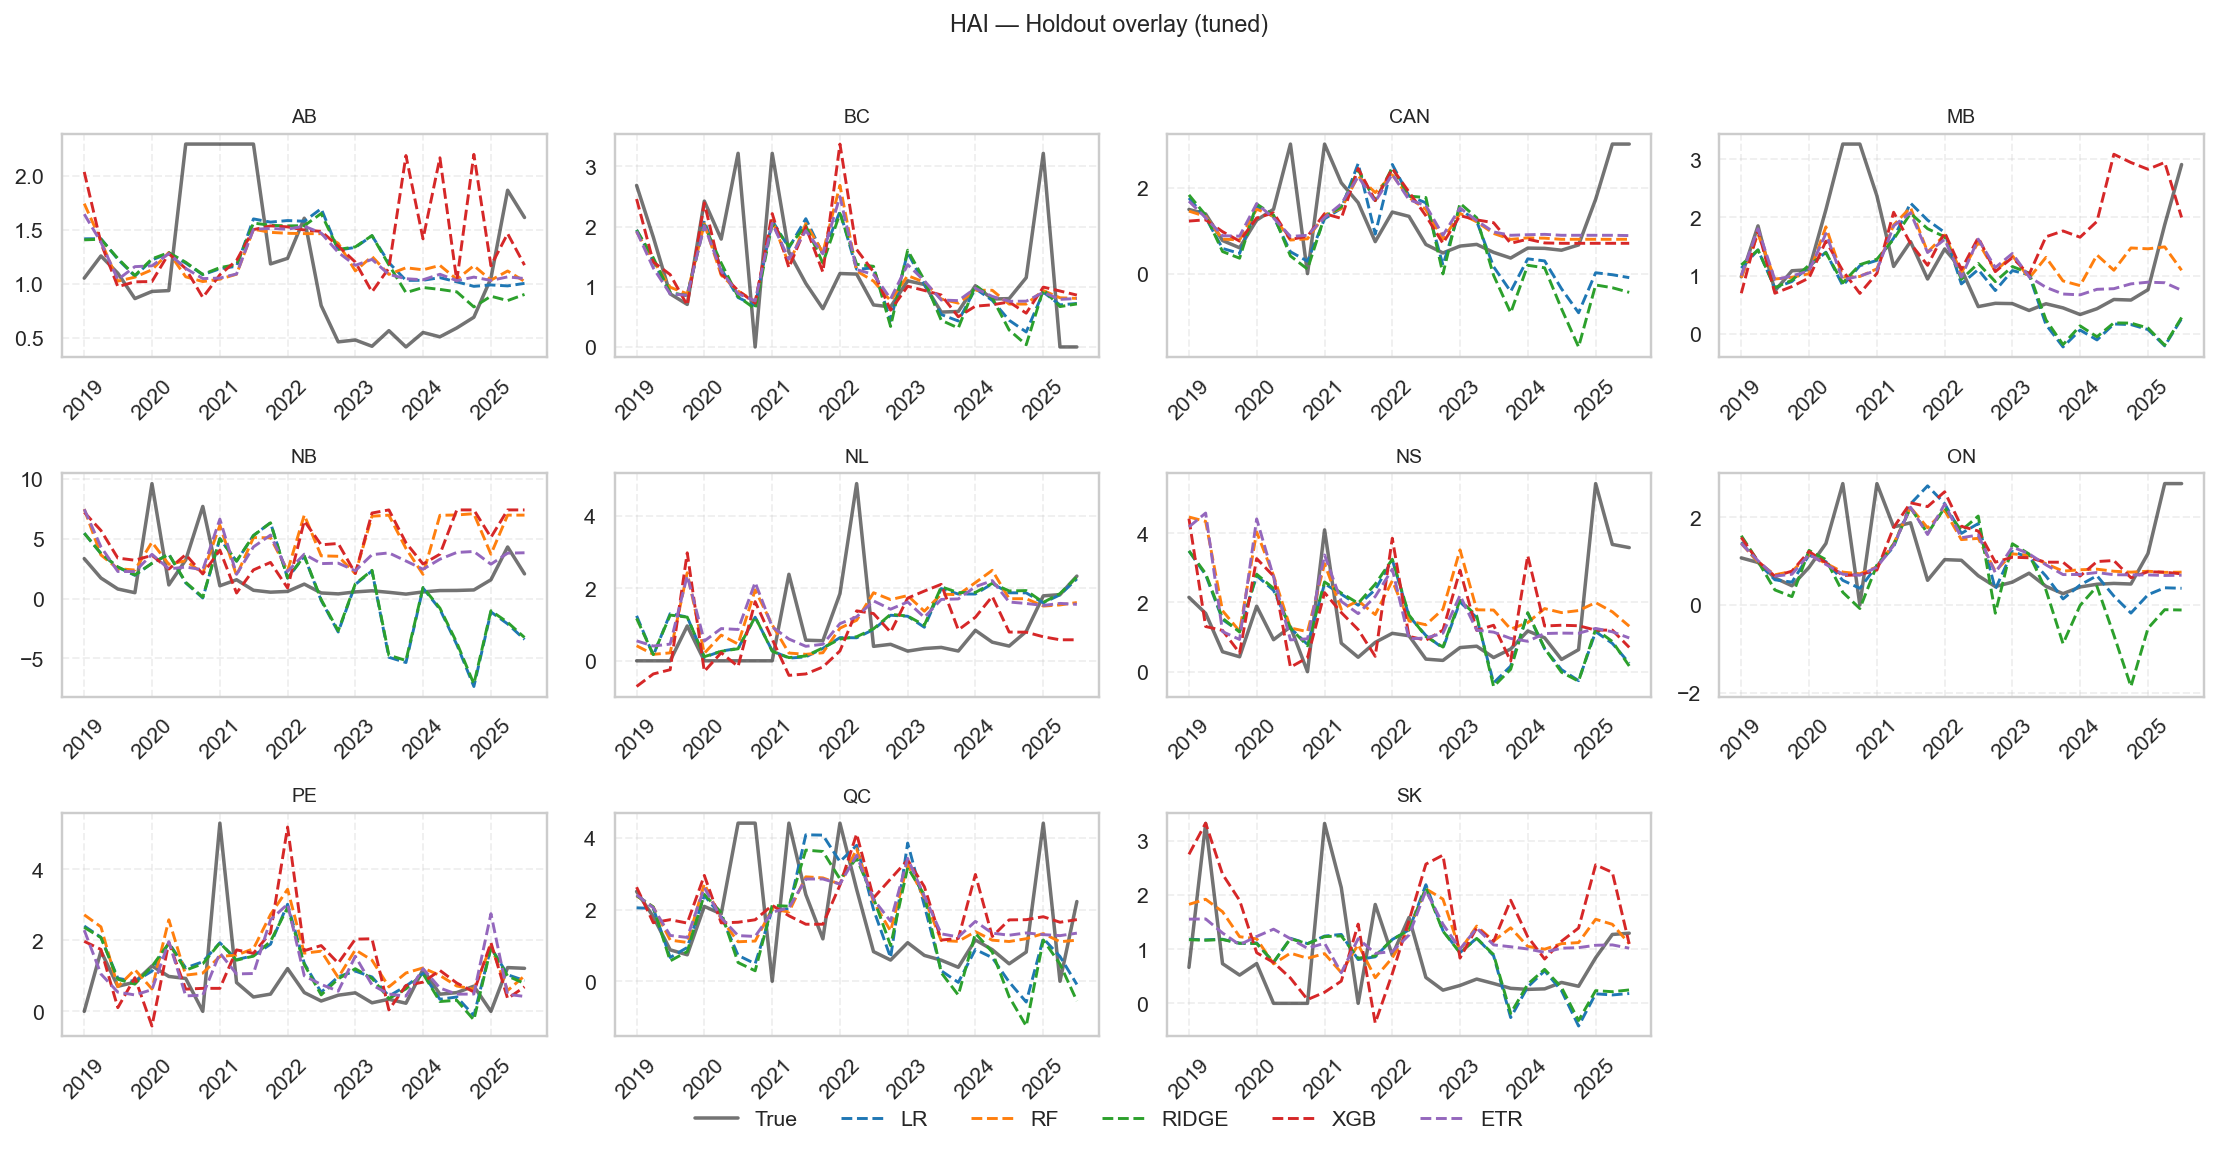

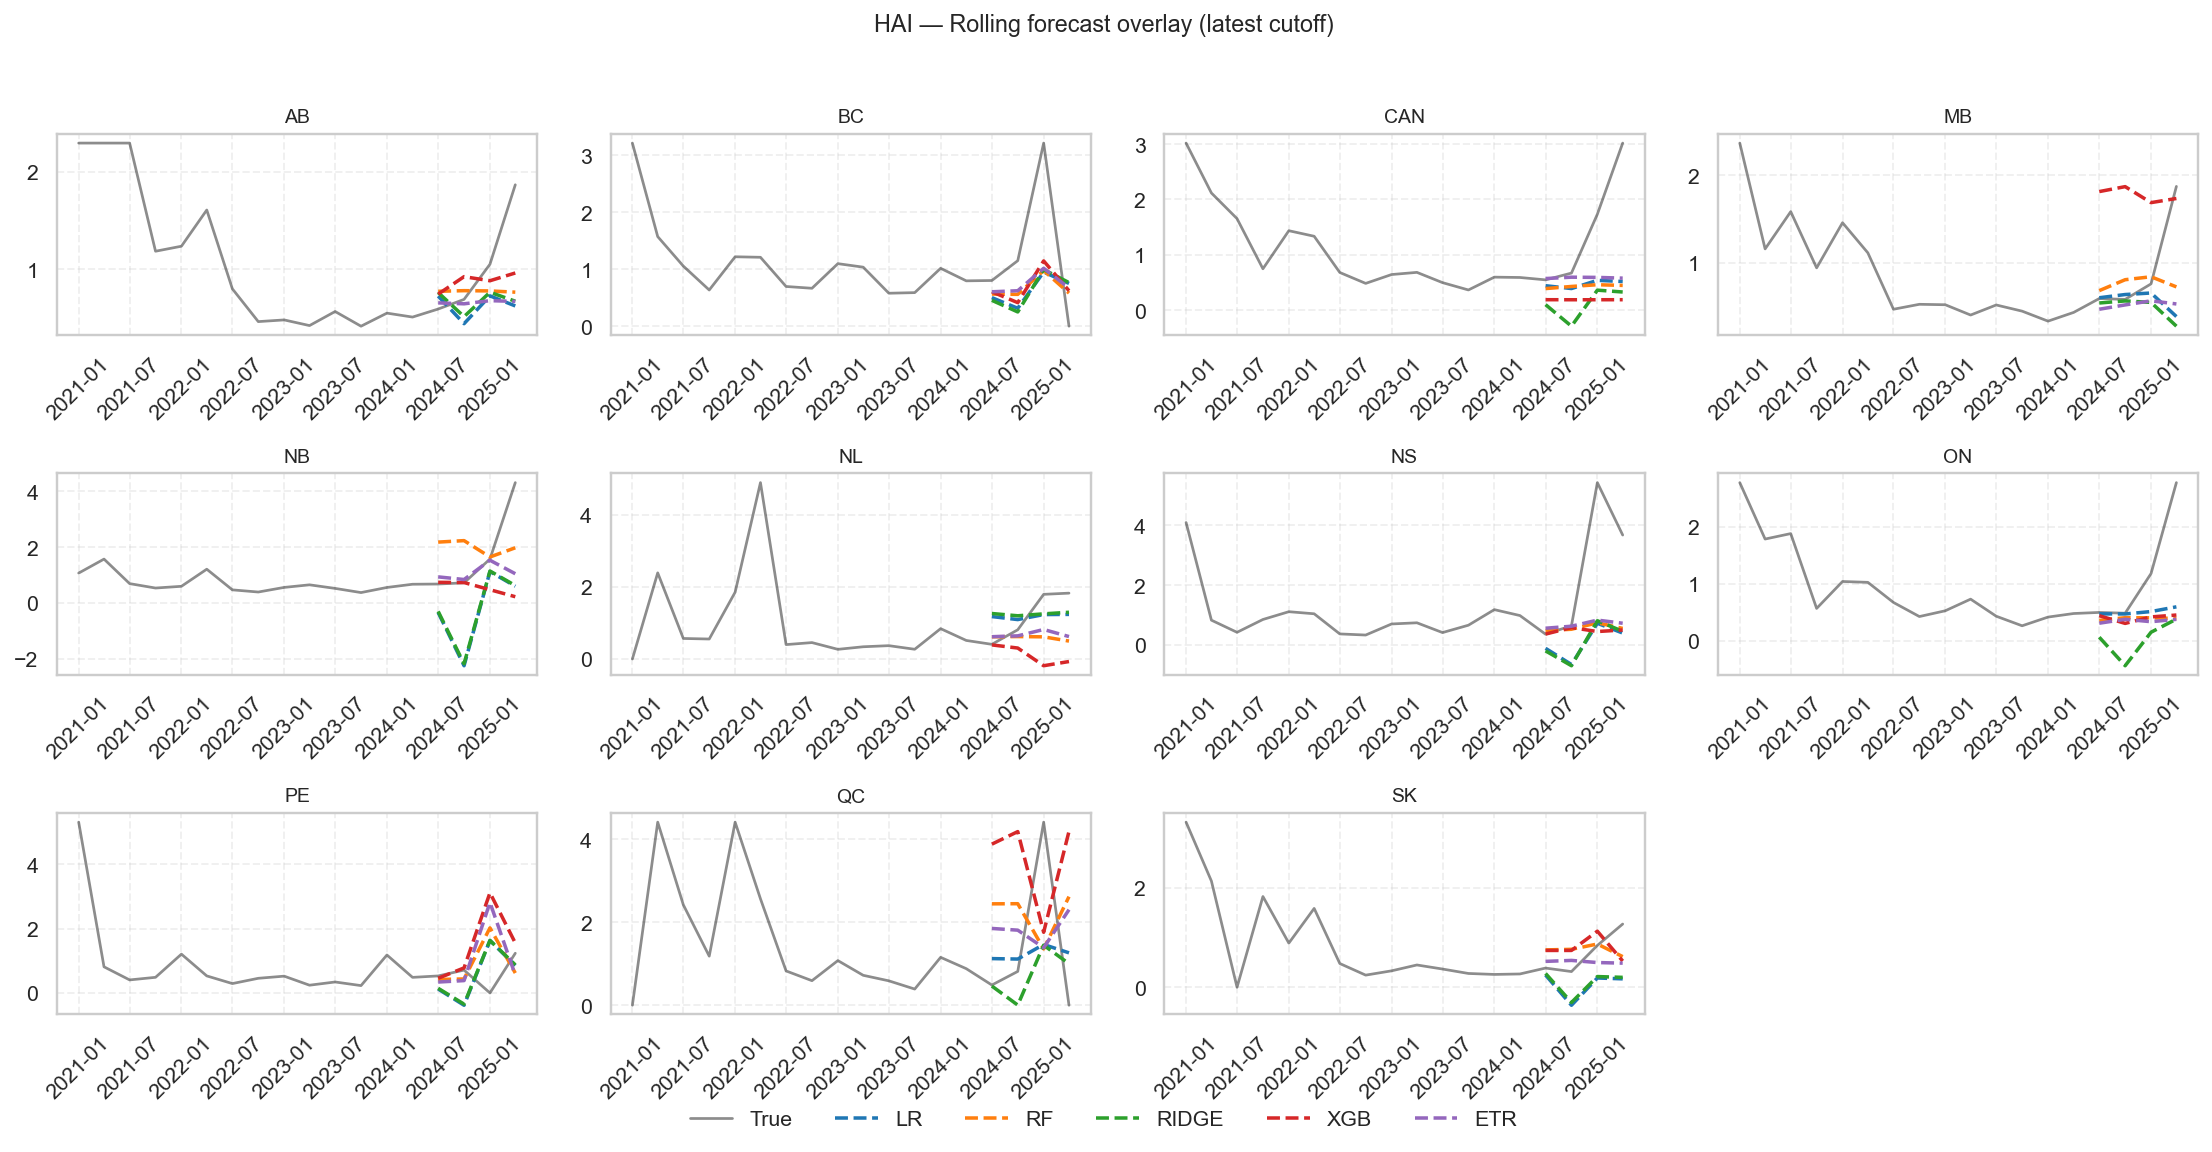

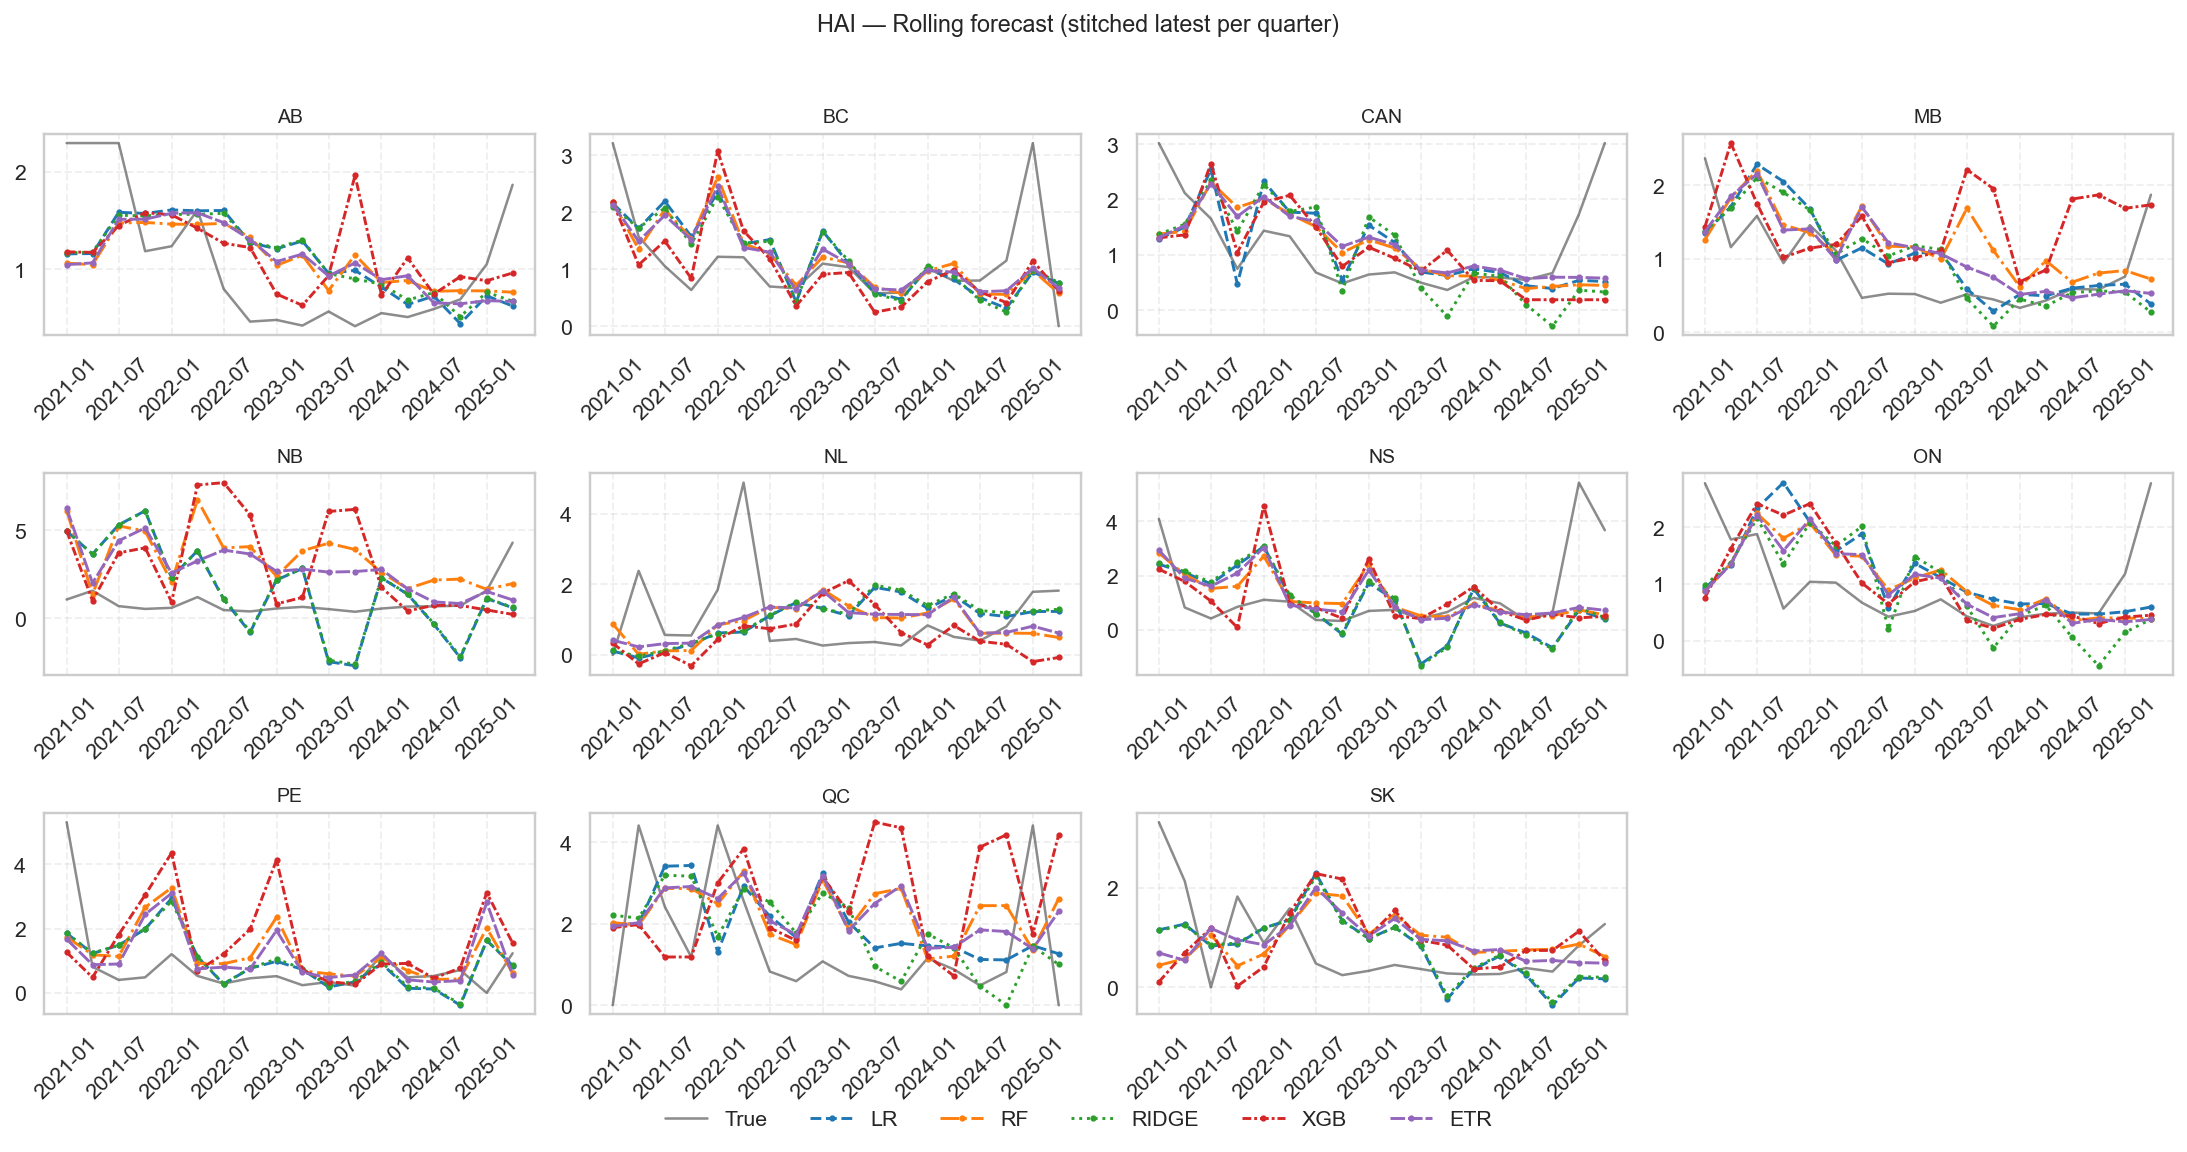


=== Heatmaps & Rankings (Holdout) ===


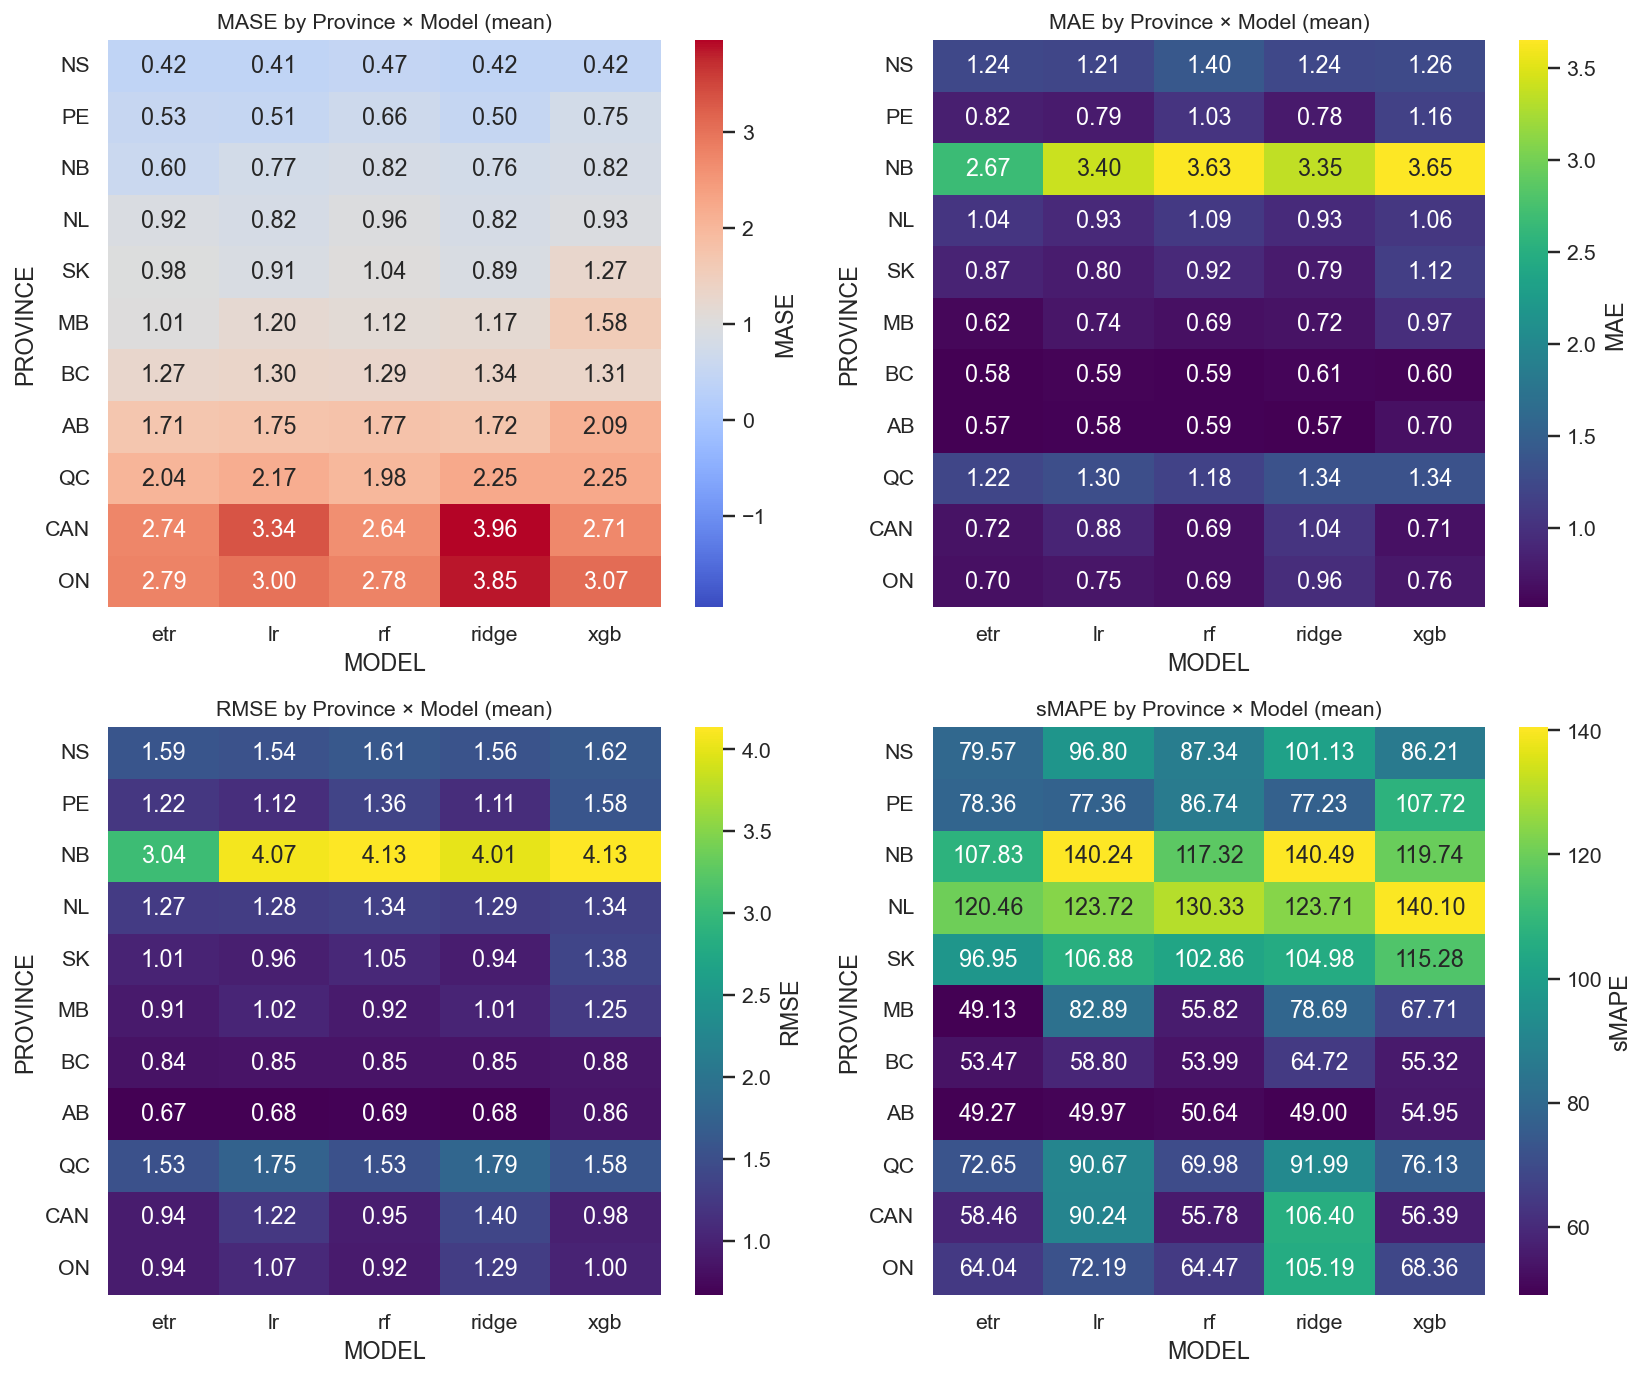

Leaderboard (holdout by MASE):


model  wins  avg_rank  med_rank  mean_metric  n_provinces
0    ETR     4  2.000000       2.0     1.364817           11
1     RF     3  3.000000       4.0     1.411286           11
2     LR     2  2.636364       3.0     1.471300           11
3  RIDGE     2  3.090909       3.0     1.607112           11
4    XGB     0  4.272727       4.0     1.564761           11


=== Heatmaps & Rankings (Rolling) ===


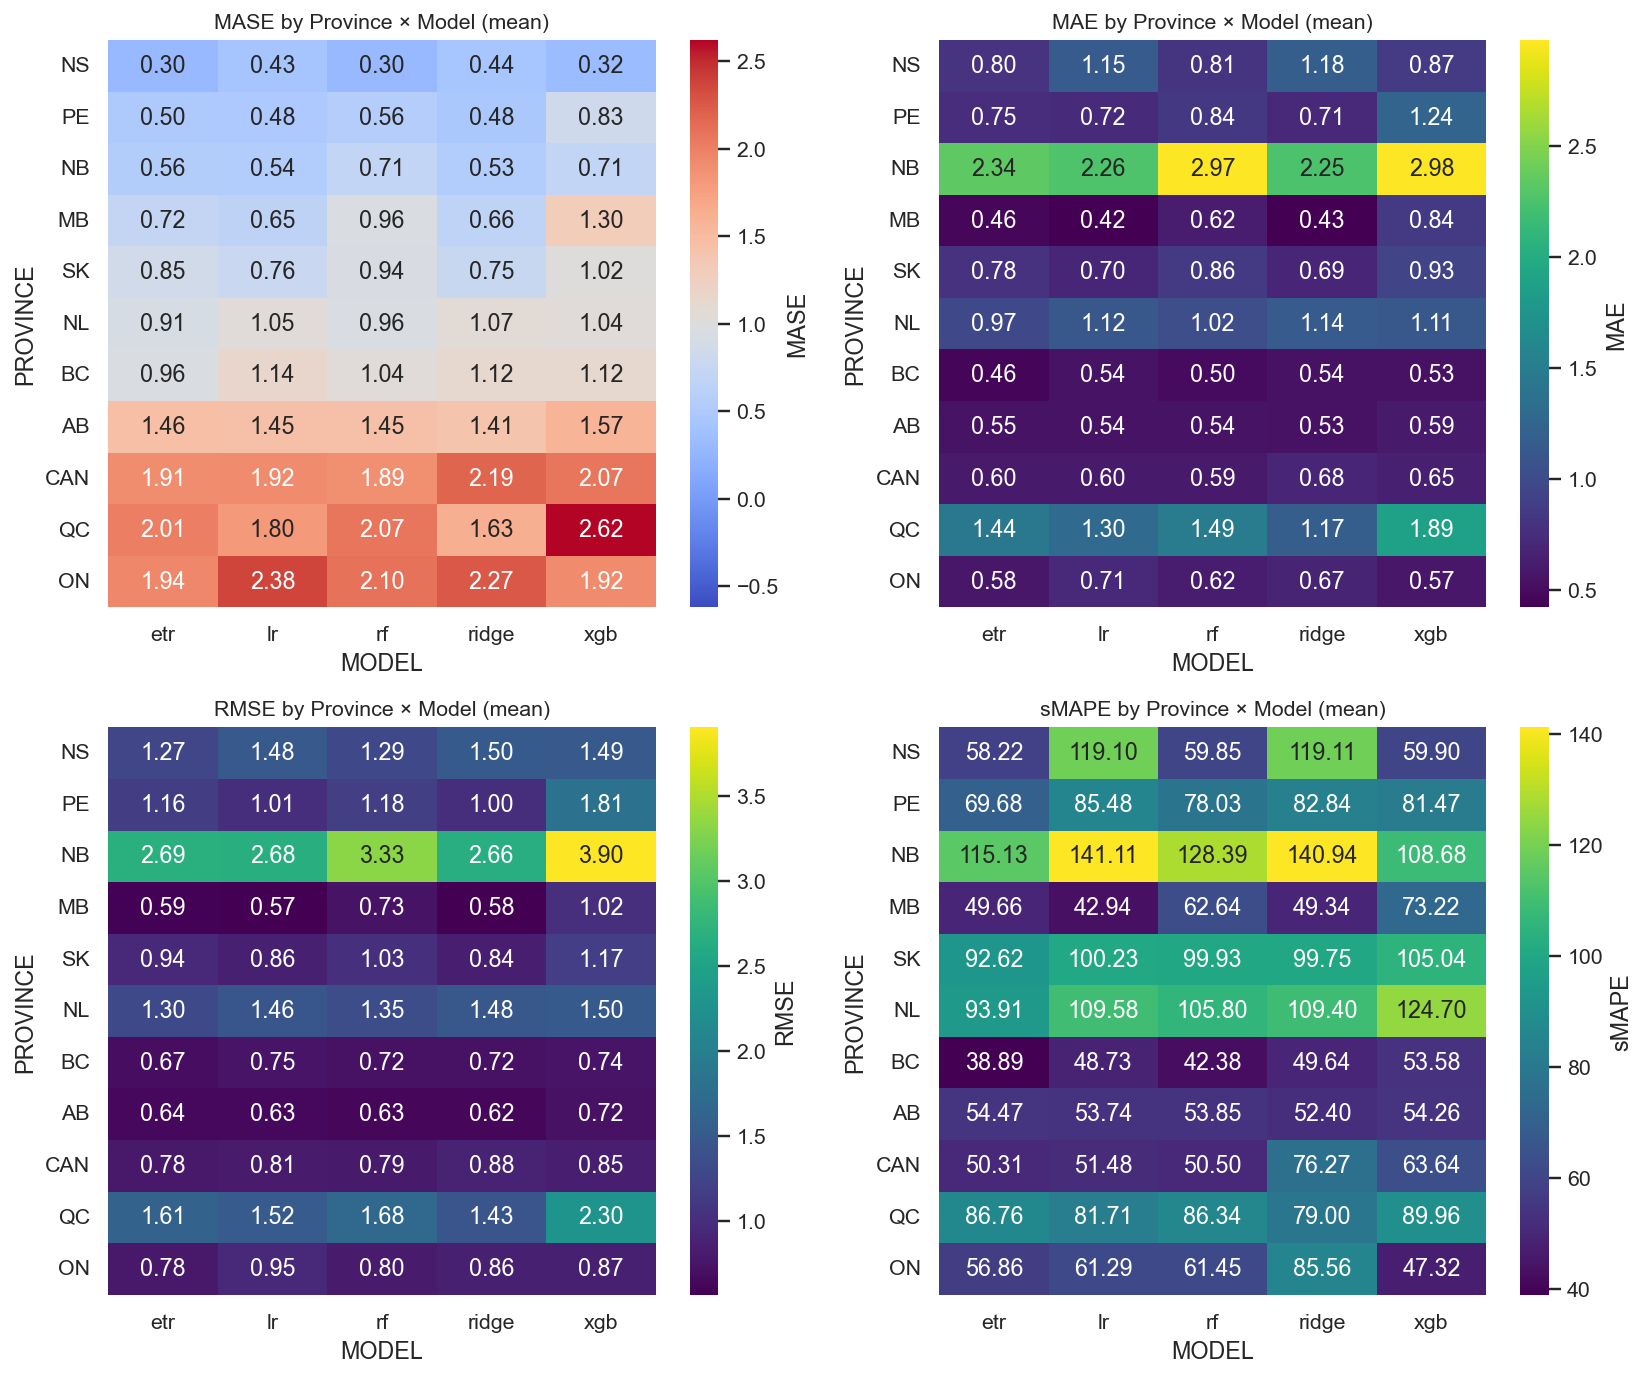

Leaderboard (rolling by MASE):


model  wins  avg_rank  med_rank  mean_metric  n_provinces
0  RIDGE     5  2.727273       2.0     1.153006           11
1    ETR     4  2.272727       3.0     1.111842           11
2     LR     1  2.909091       2.0     1.160976           11
3     RF     1  3.090909       3.0     1.189941           11
4    XGB     0  4.000000       4.0     1.327033           11

In [24]:

# (A) RAW input: no smooth features, predict raw target
res_raw = run_hai_experiment(
    prediction_choice=H_RUN,
    smooth_window=4,
    smooth_func="median",
    use_smooth_features=False,
    predict_smooth_target=False,
    models=ALL_MODELS,
    cutoff=CUTOFF_DATE,
    initial_roll="2012-12-31",
    roll_fh=None,         # None -> uses H
    roll_step=2,
    roll_last_k=8,
    n_iter_tune=8
)


<large>
<b>Experiment B — SMOOTHED Input</b>

Apply median smoothing with window=4 to both features and the target, then forecast the smoothed target.  
This can mitigate outliers and denominator-driven spikes in HAI at the cost of lag.
We keep all other settings identical to the RAW run for a fair comparison.
</large>



=== CONFIG ===
Mode=same_quarter_next_year | H=4 | season=4
Smooth: window=4, func=median, featS=True, targetSm=True
Features: ['hai_raw_lag4', 'hai_raw_lag8', 'dwelling_starts_lag4', 'pop_change_q_lag4', 'needed_units_q_lag4', 'hai_roll_lag4', 'hai_roll_lag8']
Holdout: Train 1992-01-01 → 2018-10-01 | Test 2019-01-01 → 2025-07-01
🔁 Loading cached best parameters from best_params_cache_hai_h4_s4_median_featS_tSm.json

=== HAI — Holdout averages across provinces (tuned) ===


MAE   RMSE   sMAPE   MASE
model                             
etr    0.759  0.881  64.157  1.298
rf     0.813  0.957  65.266  1.322
xgb    0.952  1.209  66.374  1.413
ridge  1.024  1.271  68.839  1.323
lr     1.063  1.328  70.860  1.332

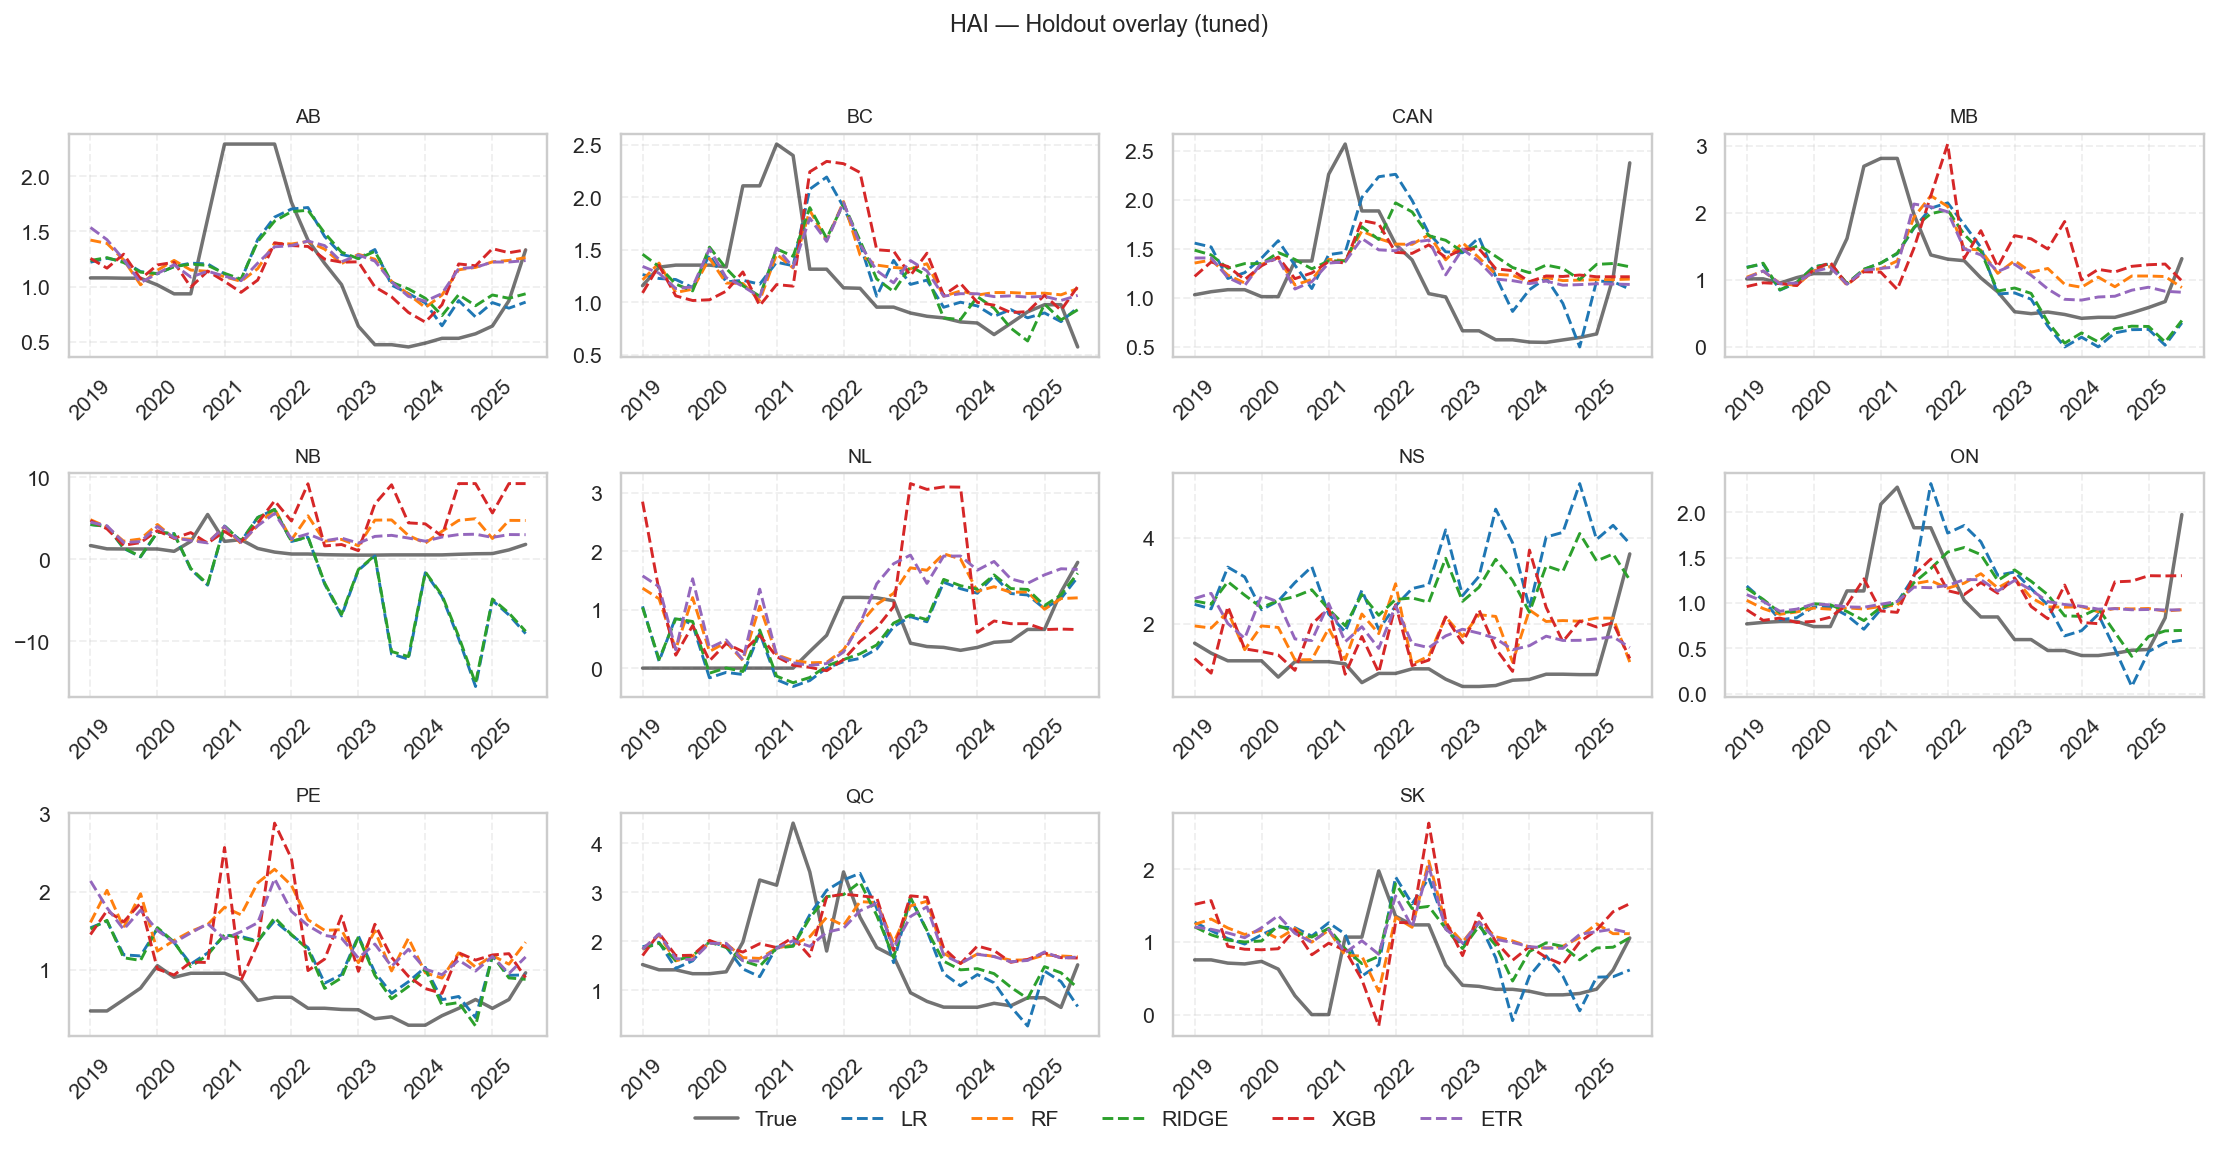

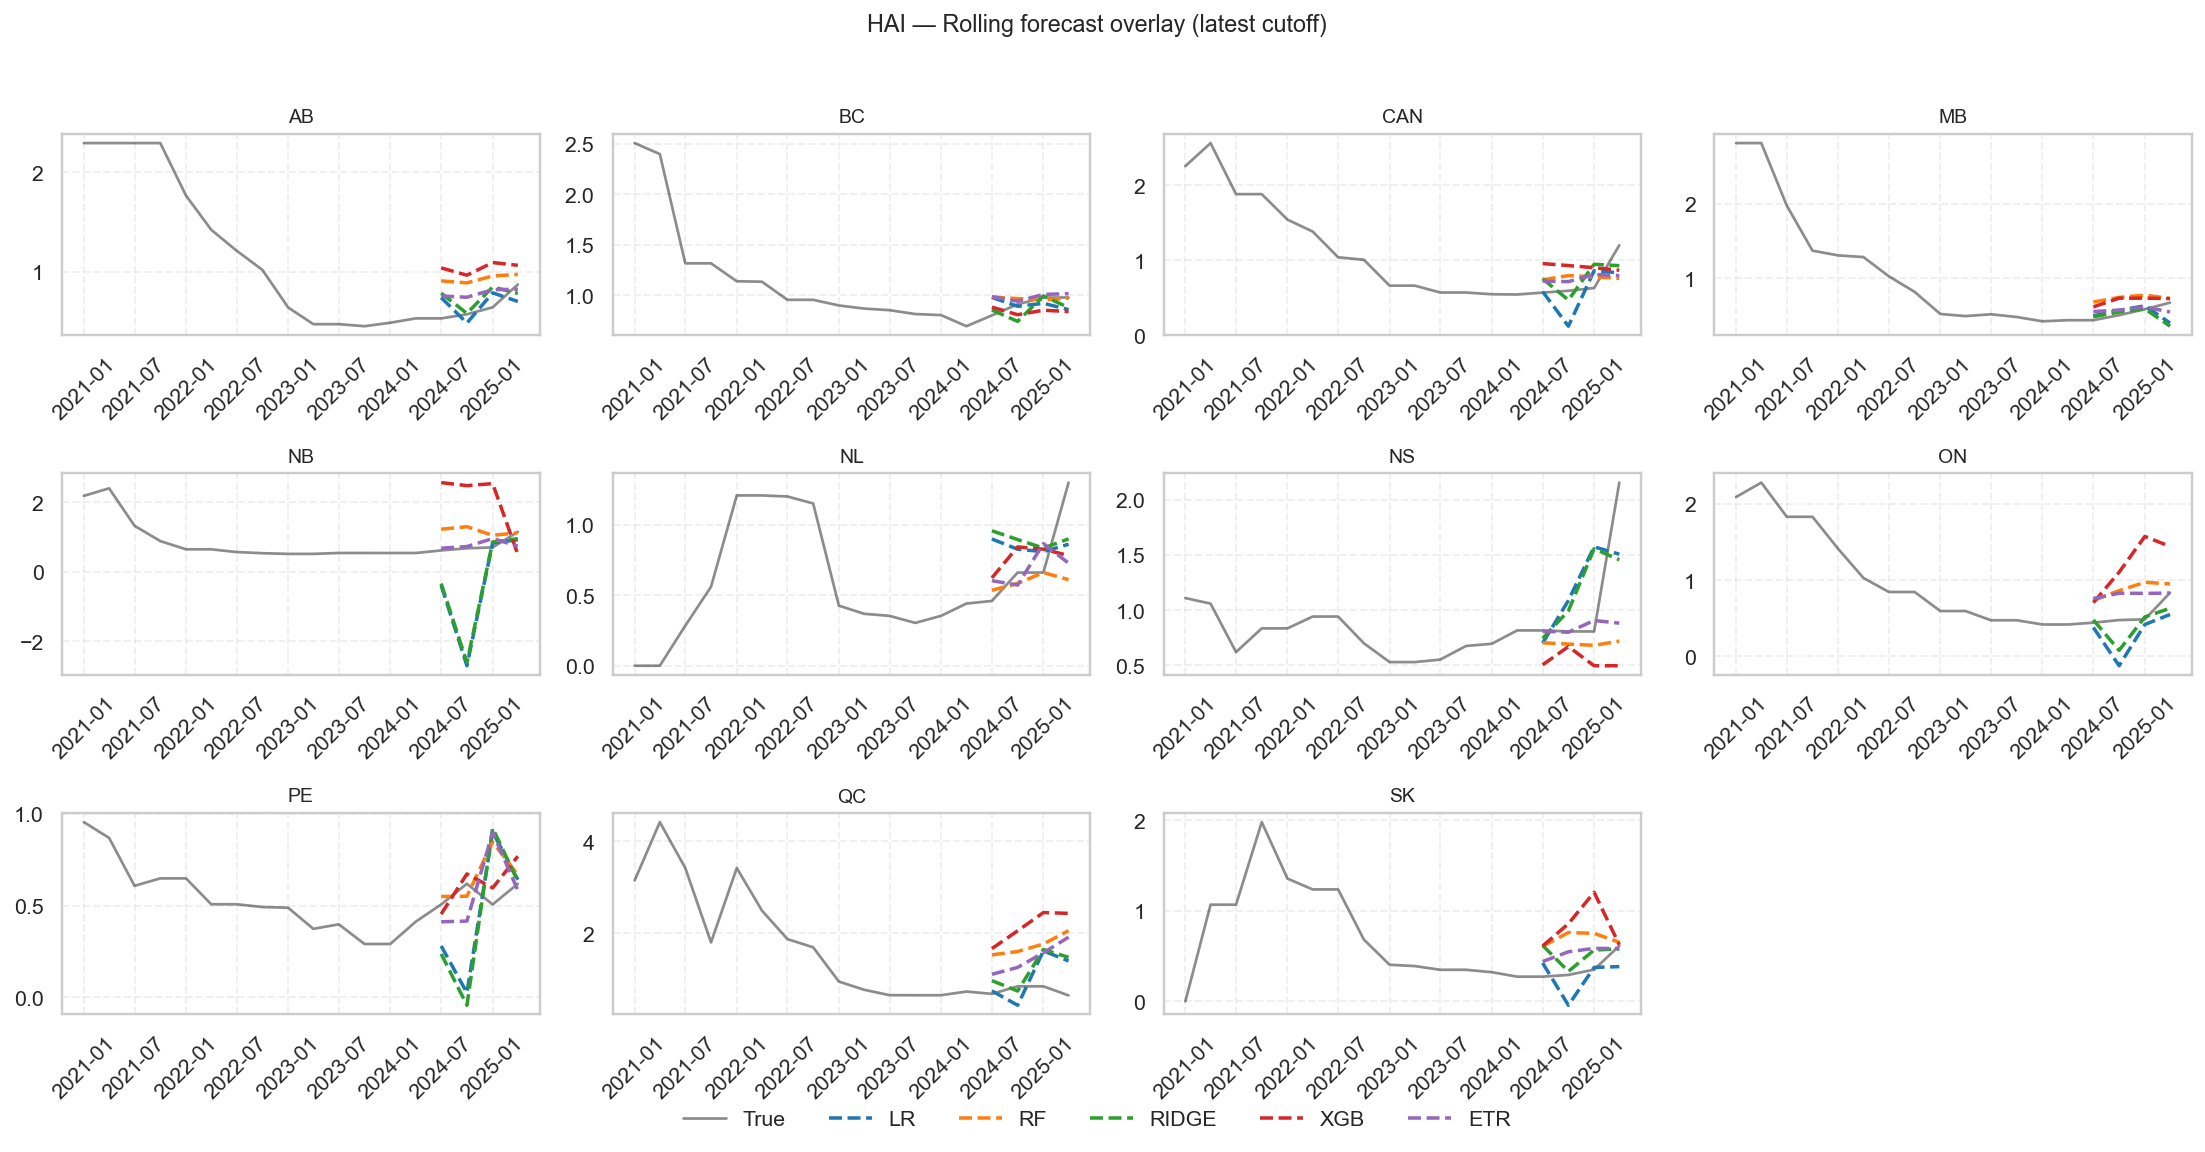

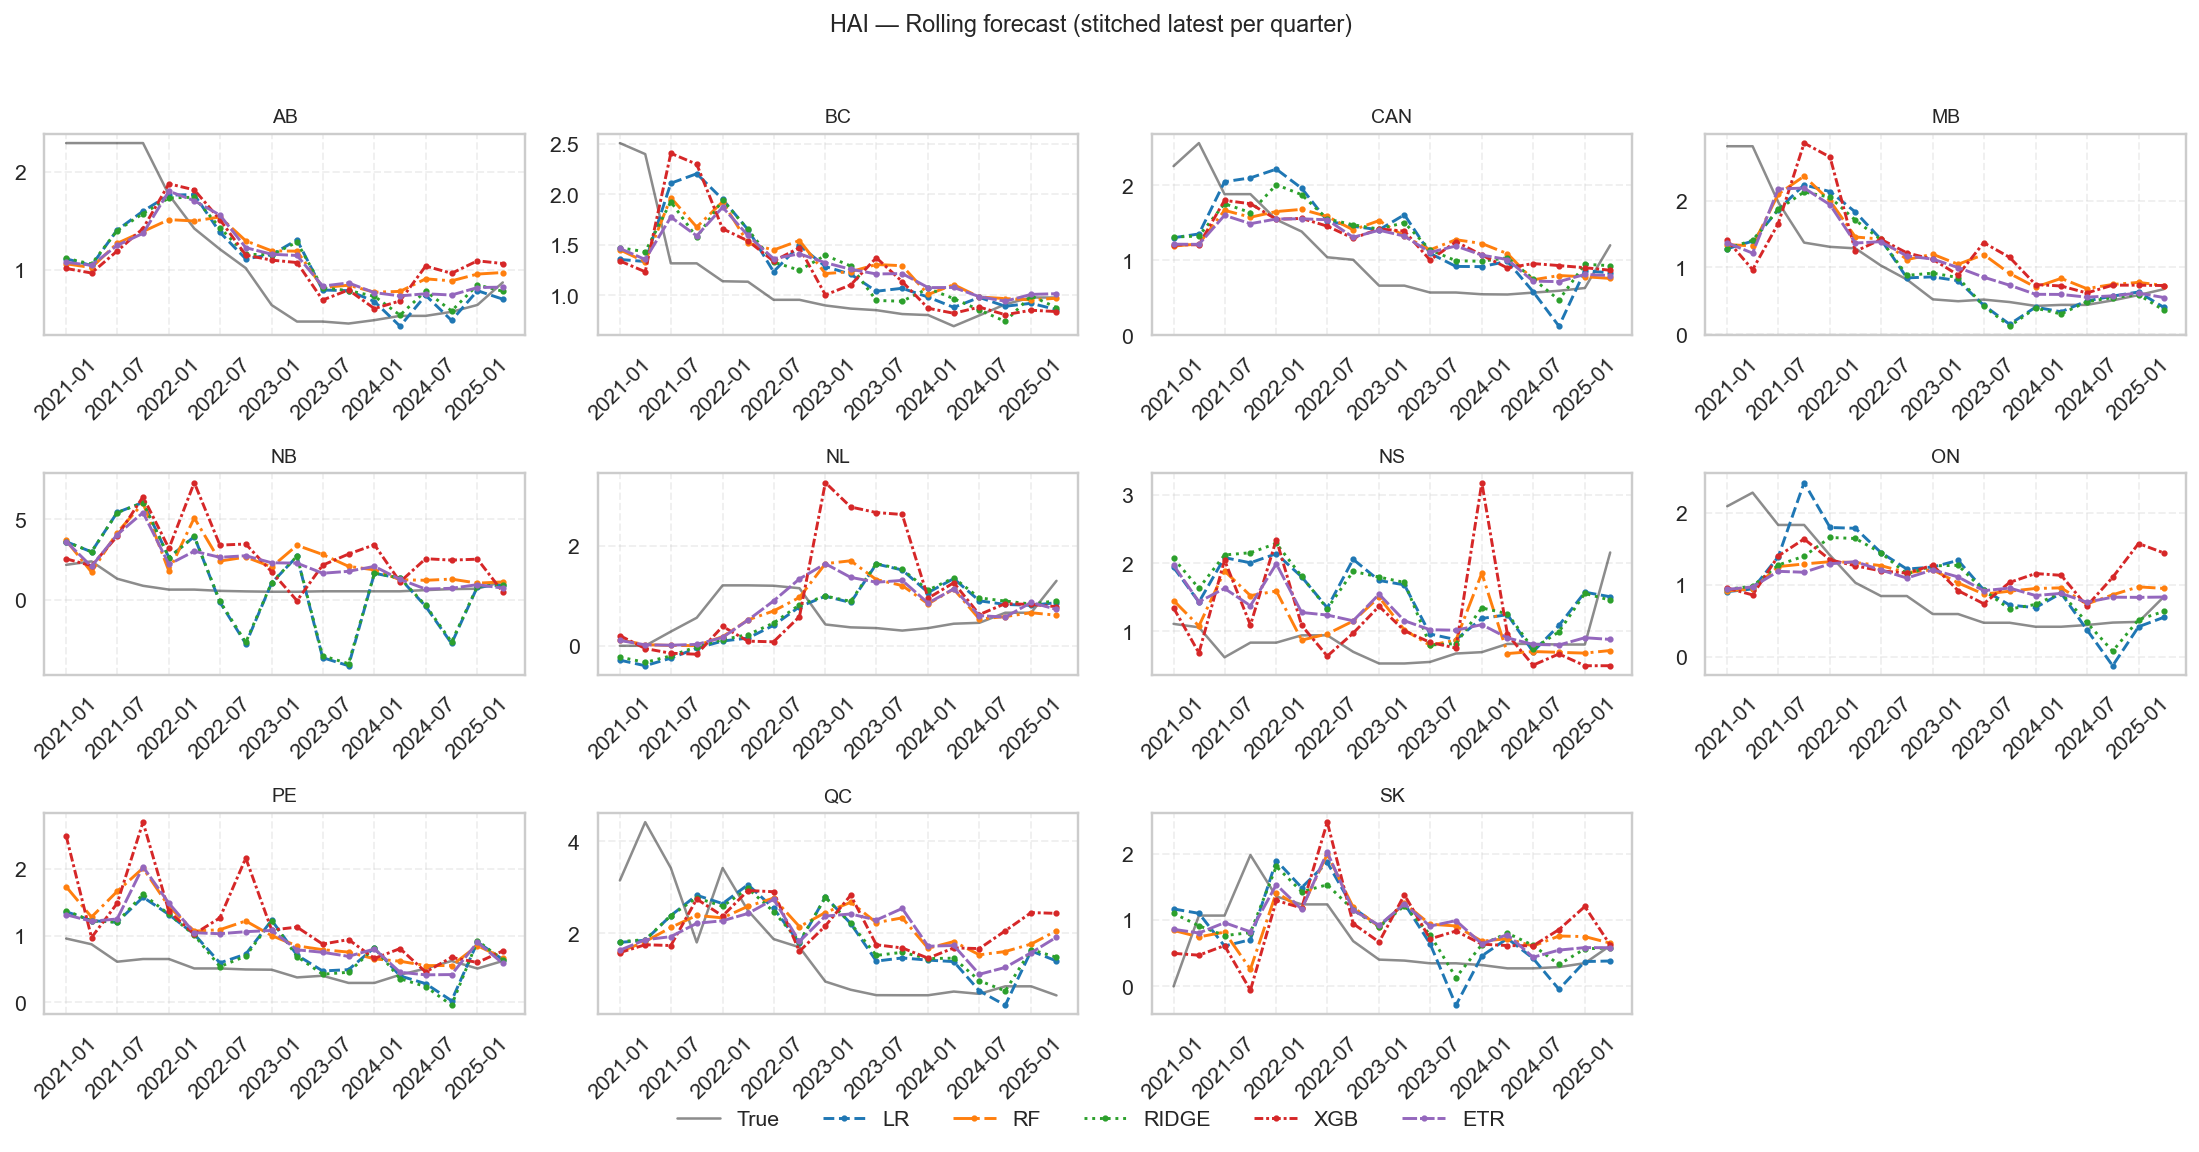


=== Heatmaps & Rankings (Holdout) ===


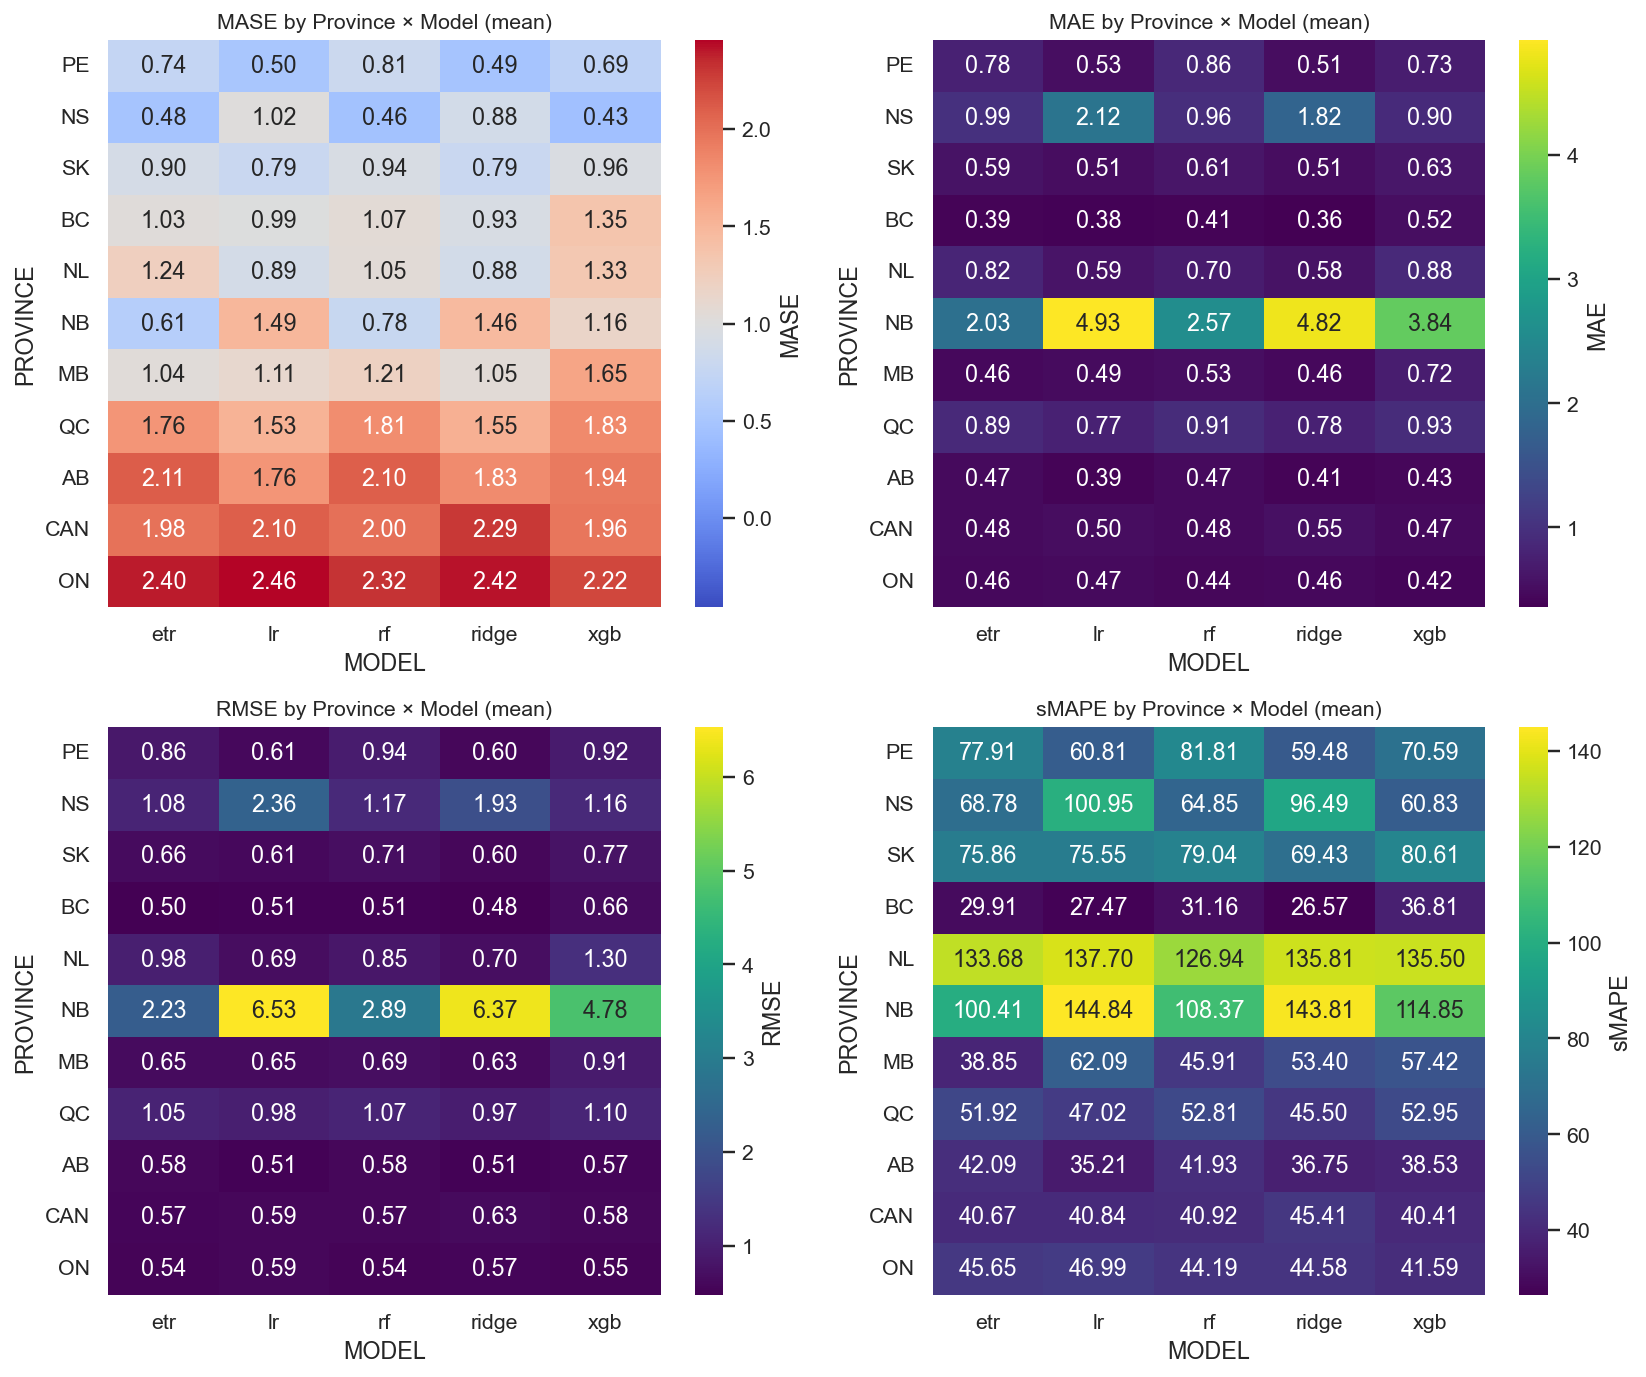

Leaderboard (holdout by MASE):


model  wins  avg_rank  med_rank  mean_metric  n_provinces
0  RIDGE     3  2.545455       2.0     1.323050           11
1     LR     3  2.818182       2.0     1.331966           11
2    XGB     3  3.363636       3.0     1.412628           11
3    ETR     2  2.909091       3.0     1.298449           11
4     RF     0  3.363636       4.0     1.321838           11


=== Heatmaps & Rankings (Rolling) ===


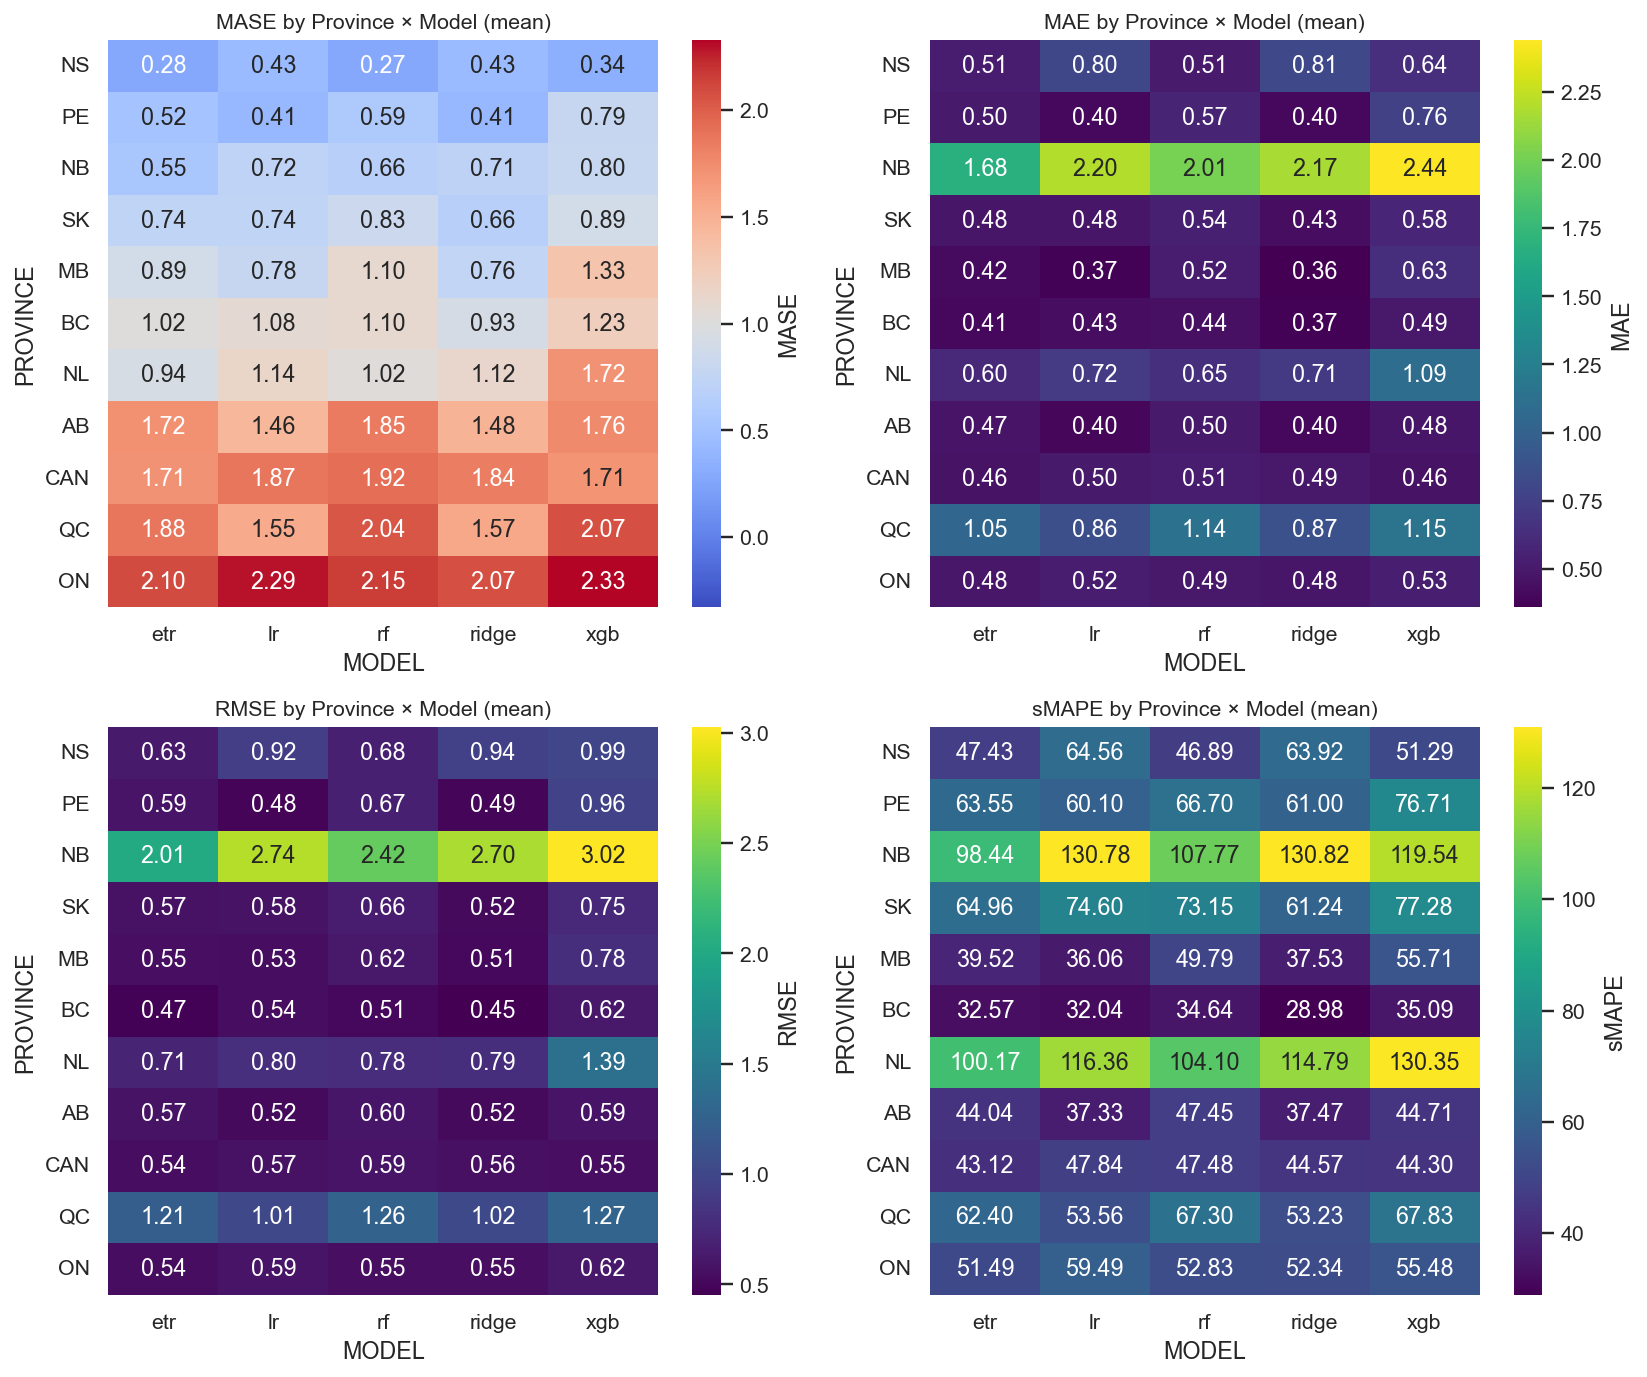

Leaderboard (rolling by MASE):


model  wins  avg_rank  med_rank  mean_metric  n_provinces
0  RIDGE     5  2.090909       2.0     1.114546           11
1    ETR     2  2.272727       2.0     1.141963           11
2     LR     2  2.909091       3.0     1.158824           11
3     RF     1  3.454545       4.0     1.247320           11
4    XGB     1  4.272727       5.0     1.375105           11

In [25]:

# (B) SMOOTHED input: smooth features + predict smoothed target
res_smooth = run_hai_experiment(
    prediction_choice=H_RUN,
    smooth_window=4,
    smooth_func="median",
    use_smooth_features=True,
    predict_smooth_target=True,
    models=ALL_MODELS,
    cutoff=CUTOFF_DATE,
    initial_roll="2012-12-31",
    roll_fh=None,         # None -> uses H
    roll_step=2,
    roll_last_k=8,
    n_iter_tune=8
)


<large>
<b>Cache Paths</b>

Each run reports the path to its cached best-params bundle.  
Use these caches to reproduce results quickly or to run inference without re-tuning.
</large>


In [26]:

print("\nCache (RAW):    ", res_raw["cache_path"])
print("Cache (SMOOTH): ", res_smooth["cache_path"])



Cache (RAW):     best_params_cache_hai_h4_s4_median_featN_tRaw.json
Cache (SMOOTH):  best_params_cache_hai_h4_s4_median_featS_tSm.json


## "next_quarter" (H=1)

In [27]:
# Horizon choice: "next_quarter" (H=1) or "same_quarter_next_year" (H=4)
PREDICTION_CHOICE = "next_quarter"

<large>
<b>Two Parallel Experiments</b>

We execute two otherwise identical pipelines to examine the effect of smoothing on HAI:

1) <b>RAW</b>: <i>use_smooth_features=False</i>, <i>predict_smooth_target=False</i>  
2) <b>SMOOTHED</b>: <i>use_smooth_features=True</i>, <i>predict_smooth_target=True</i>

Both runs share: models, cutoff, rolling config, and tuning budget.
</large>


In [28]:

# ===============================
# Execute RAW & SMOOTHED runs
# ===============================

# Horizon from global PREDICTION_CHOICE
H_RUN = PREDICTION_CHOICE


<large>
<b>Experiment A — RAW Input</b>

No smoothing applied to features or target.  
This establishes a baseline on the original (potentially spiky) HAI series.
Key parameters:
• <code>prediction_choice</code> = H from the global setting  
• <code>smooth_window</code> and <code>smooth_func</code> are ignored for features/target here  
• <code>n_iter_tune</code> is a lightweight tuning budget (increase for deeper search)  
• Rolling evaluation uses <code>initial_roll</code>, <code>roll_step</code>, and <code>roll_last_k</code>
</large>



=== CONFIG ===
Mode=next_quarter | H=1 | season=1
Smooth: window=4, func=median, featS=False, targetSm=False
Features: ['hai_raw_lag1', 'hai_raw_lag4', 'dwelling_starts_lag1', 'pop_change_q_lag1', 'needed_units_q_lag1']
Holdout: Train 1991-01-01 → 2018-10-01 | Test 2019-01-01 → 2025-07-01
⏳ Running tuning from scratch...
🧮 Tuning: 11 prov × 5 models × 8 trials (fh=1, season=1)
→ [1/55] AB — LR ... best MASE=1.053
→ [2/55] AB — RF ... best MASE=1.111
→ [3/55] AB — RIDGE ... best MASE=1.045
→ [4/55] AB — XGB ... best MASE=1.140
→ [5/55] AB — ETR ... best MASE=1.107
→ [6/55] BC — LR ... best MASE=1.071
→ [7/55] BC — RF ... best MASE=1.115
→ [8/55] BC — RIDGE ... best MASE=1.124
→ [9/55] BC — XGB ... best MASE=1.106
→ [10/55] BC — ETR ... best MASE=1.092
→ [11/55] CAN — LR ... best MASE=0.567
→ [12/55] CAN — RF ... best MASE=0.522
→ [13/55] CAN — RIDGE ... best MASE=0.560
→ [14/55] CAN — XGB ... best MASE=0.510
→ [15/55] CAN — ETR ... best MASE=0.526
→ [16/55] MB — LR ... best MASE=0.450


MAE   RMSE   sMAPE   MASE
model                             
etr    0.955  1.205  71.209  0.860
lr     1.063  1.341  79.701  0.918
ridge  1.108  1.368  79.495  0.918
rf     1.164  1.405  76.843  0.971
xgb    1.178  1.499  78.965  1.031

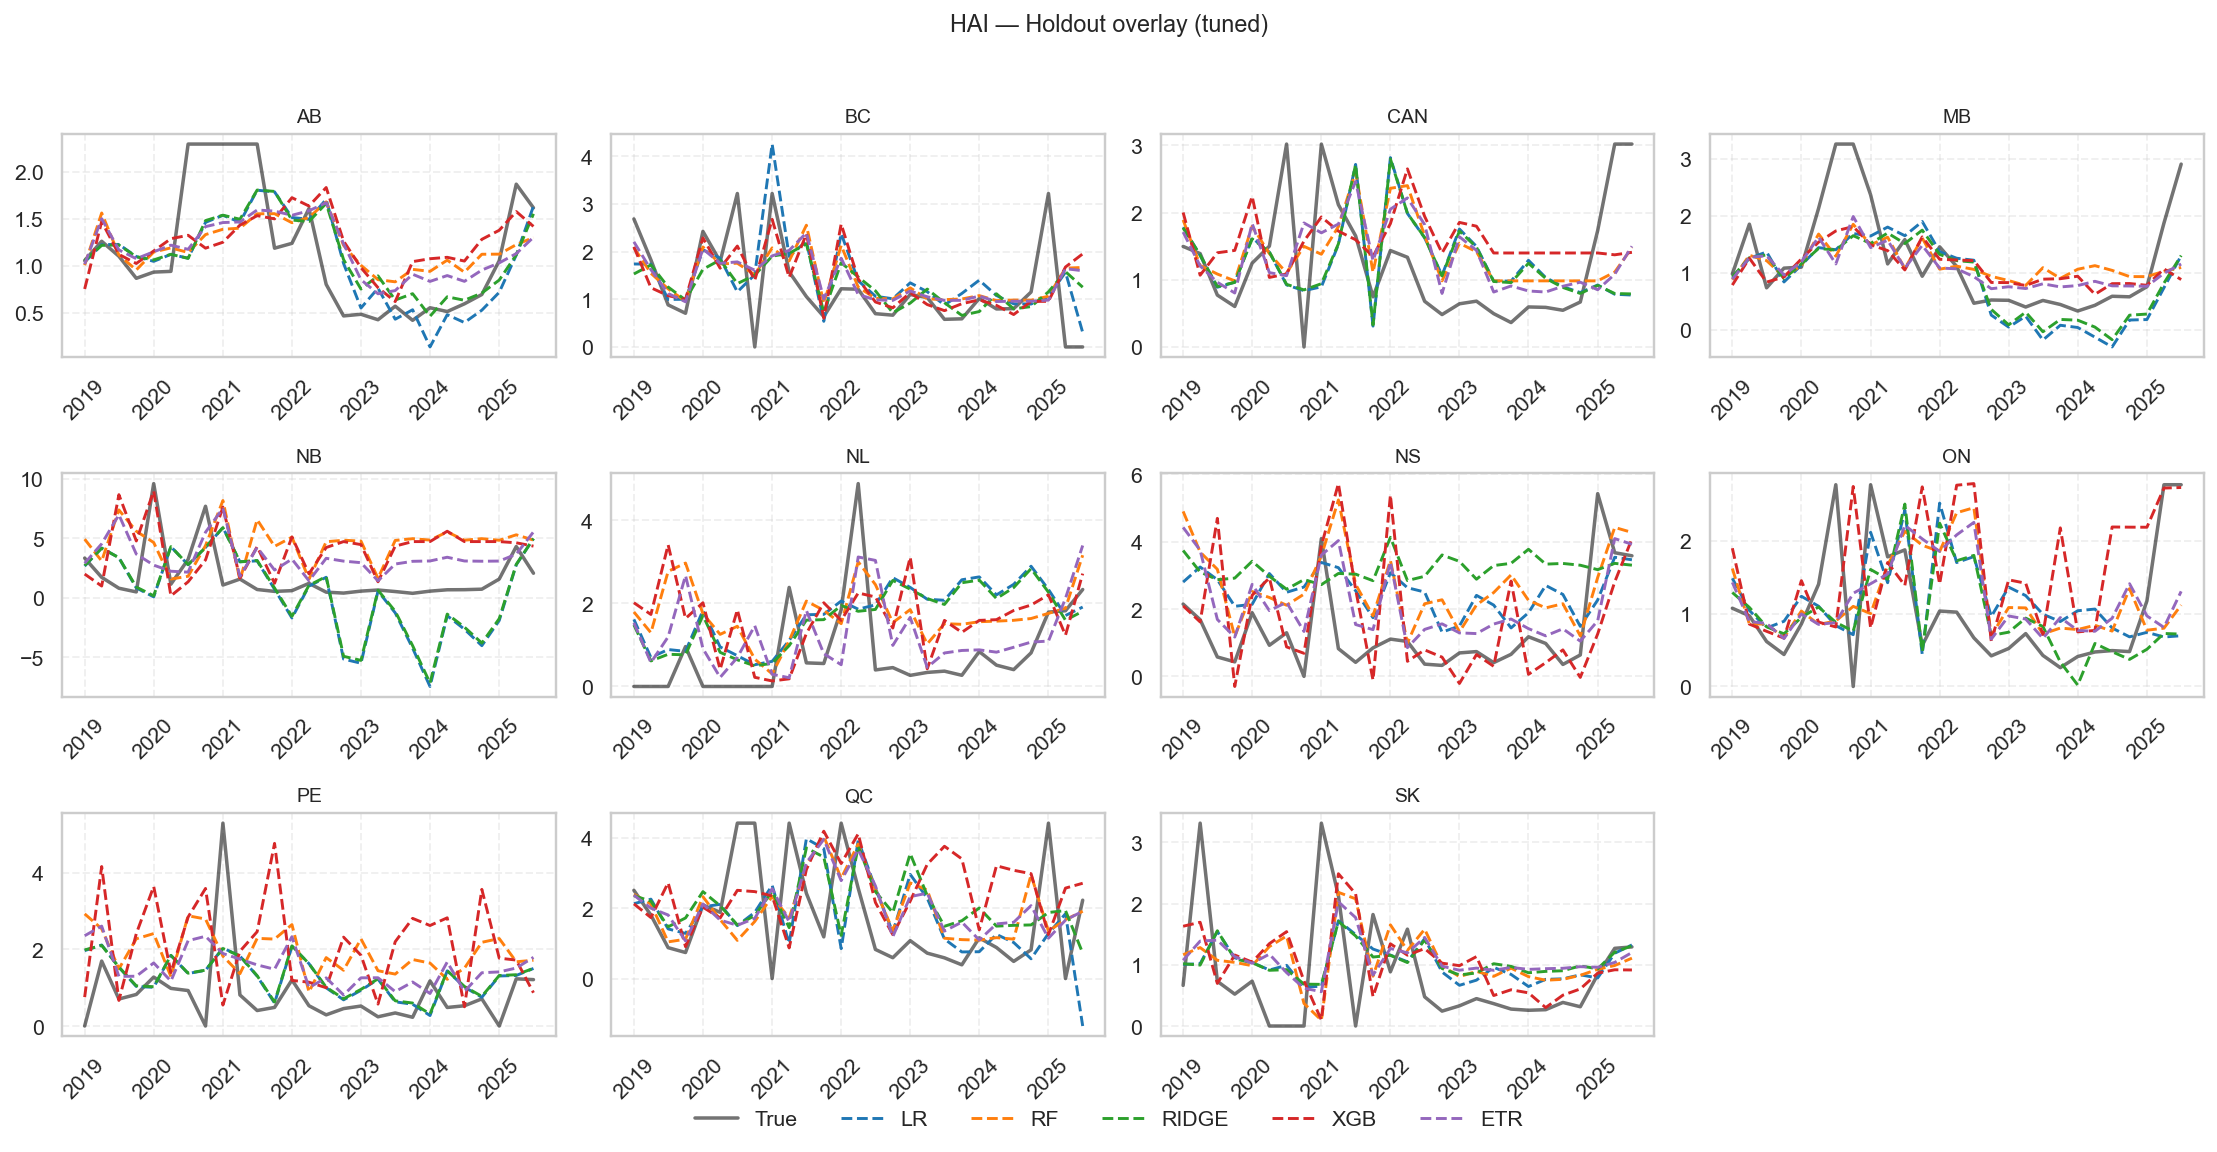

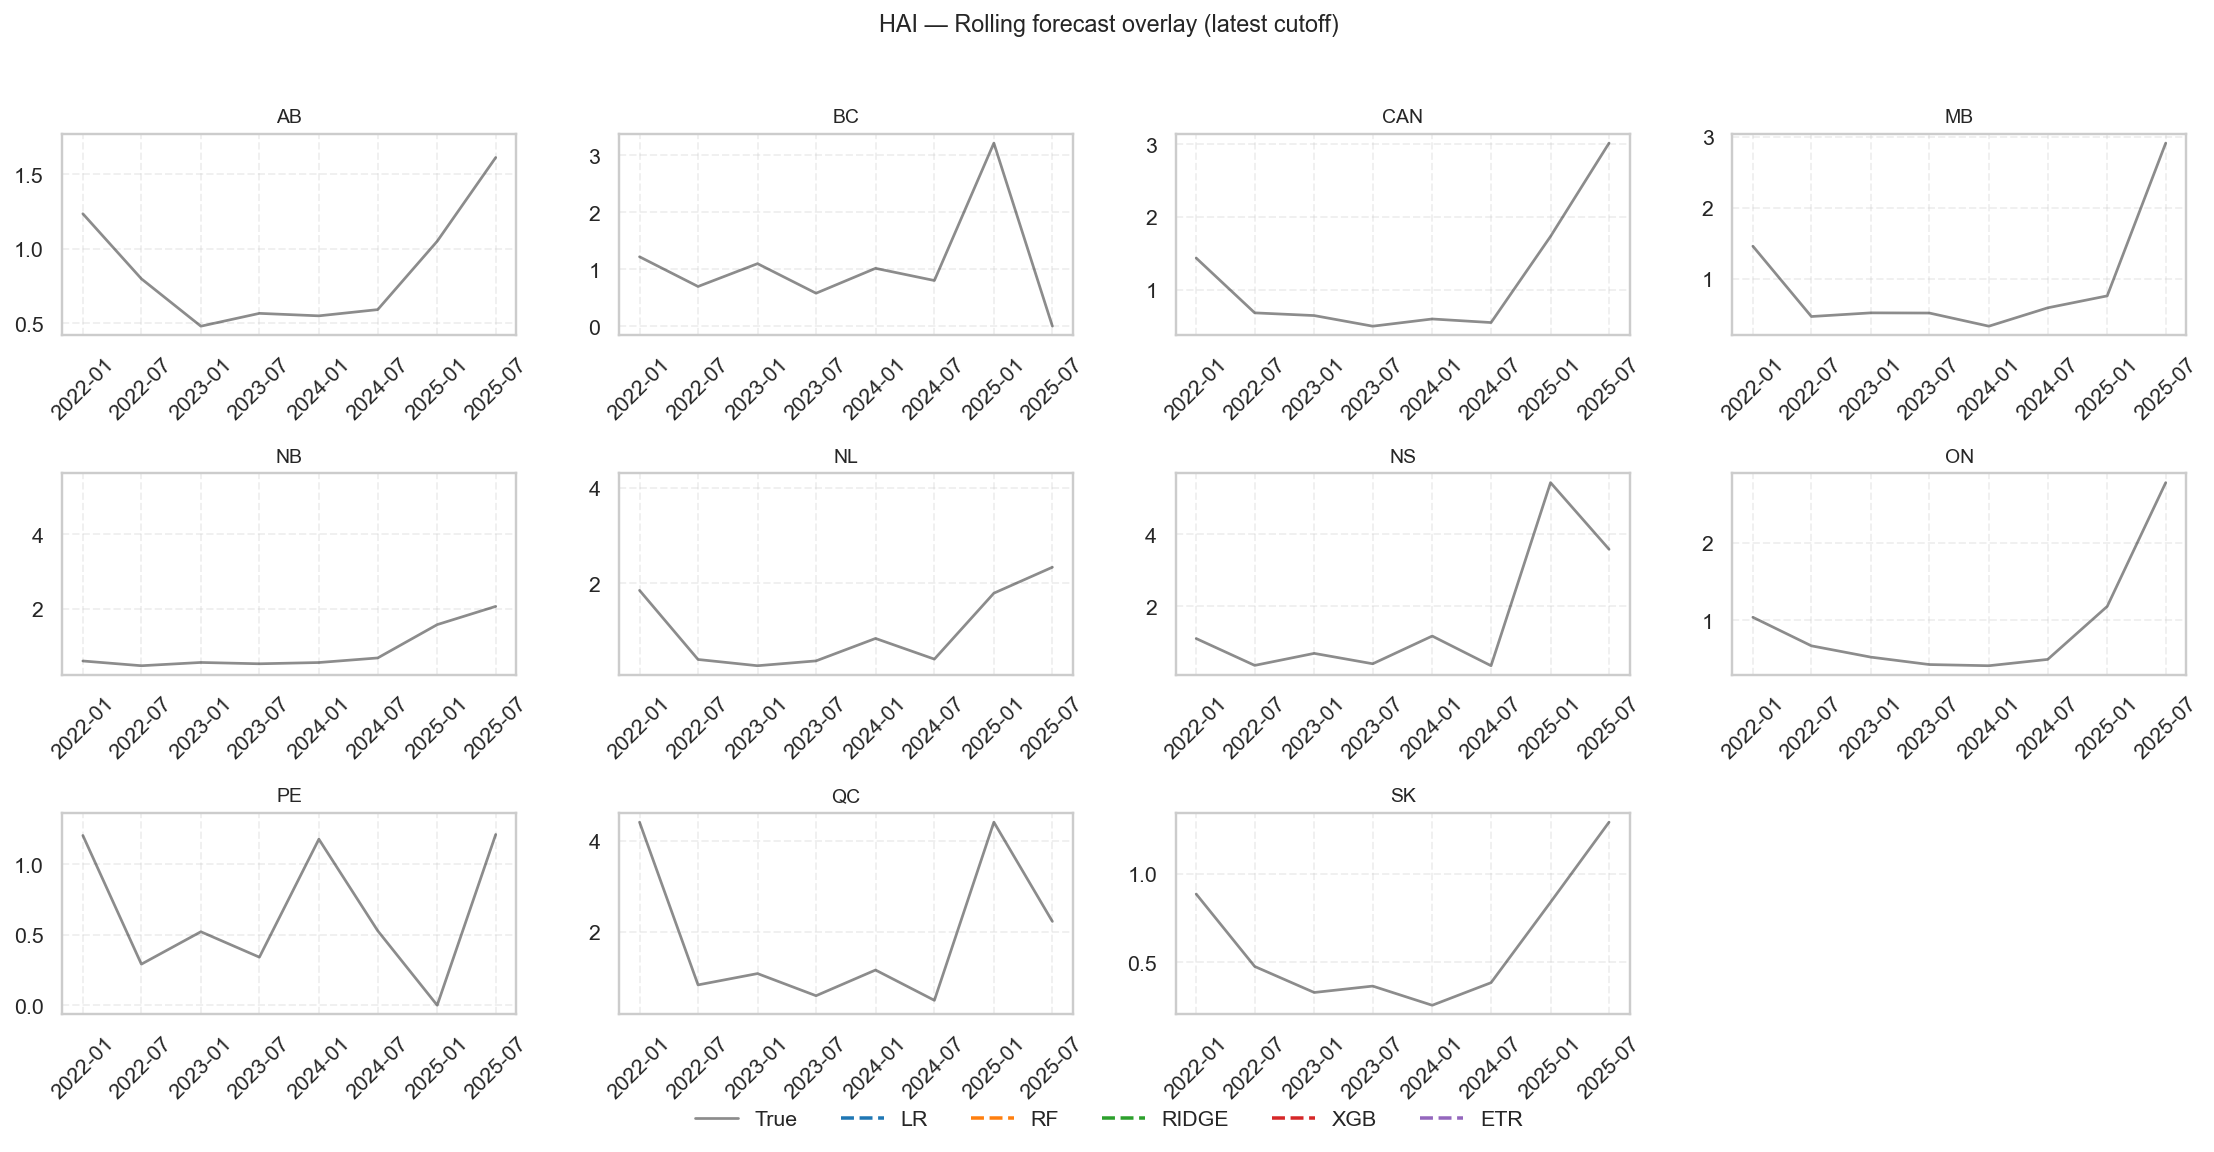

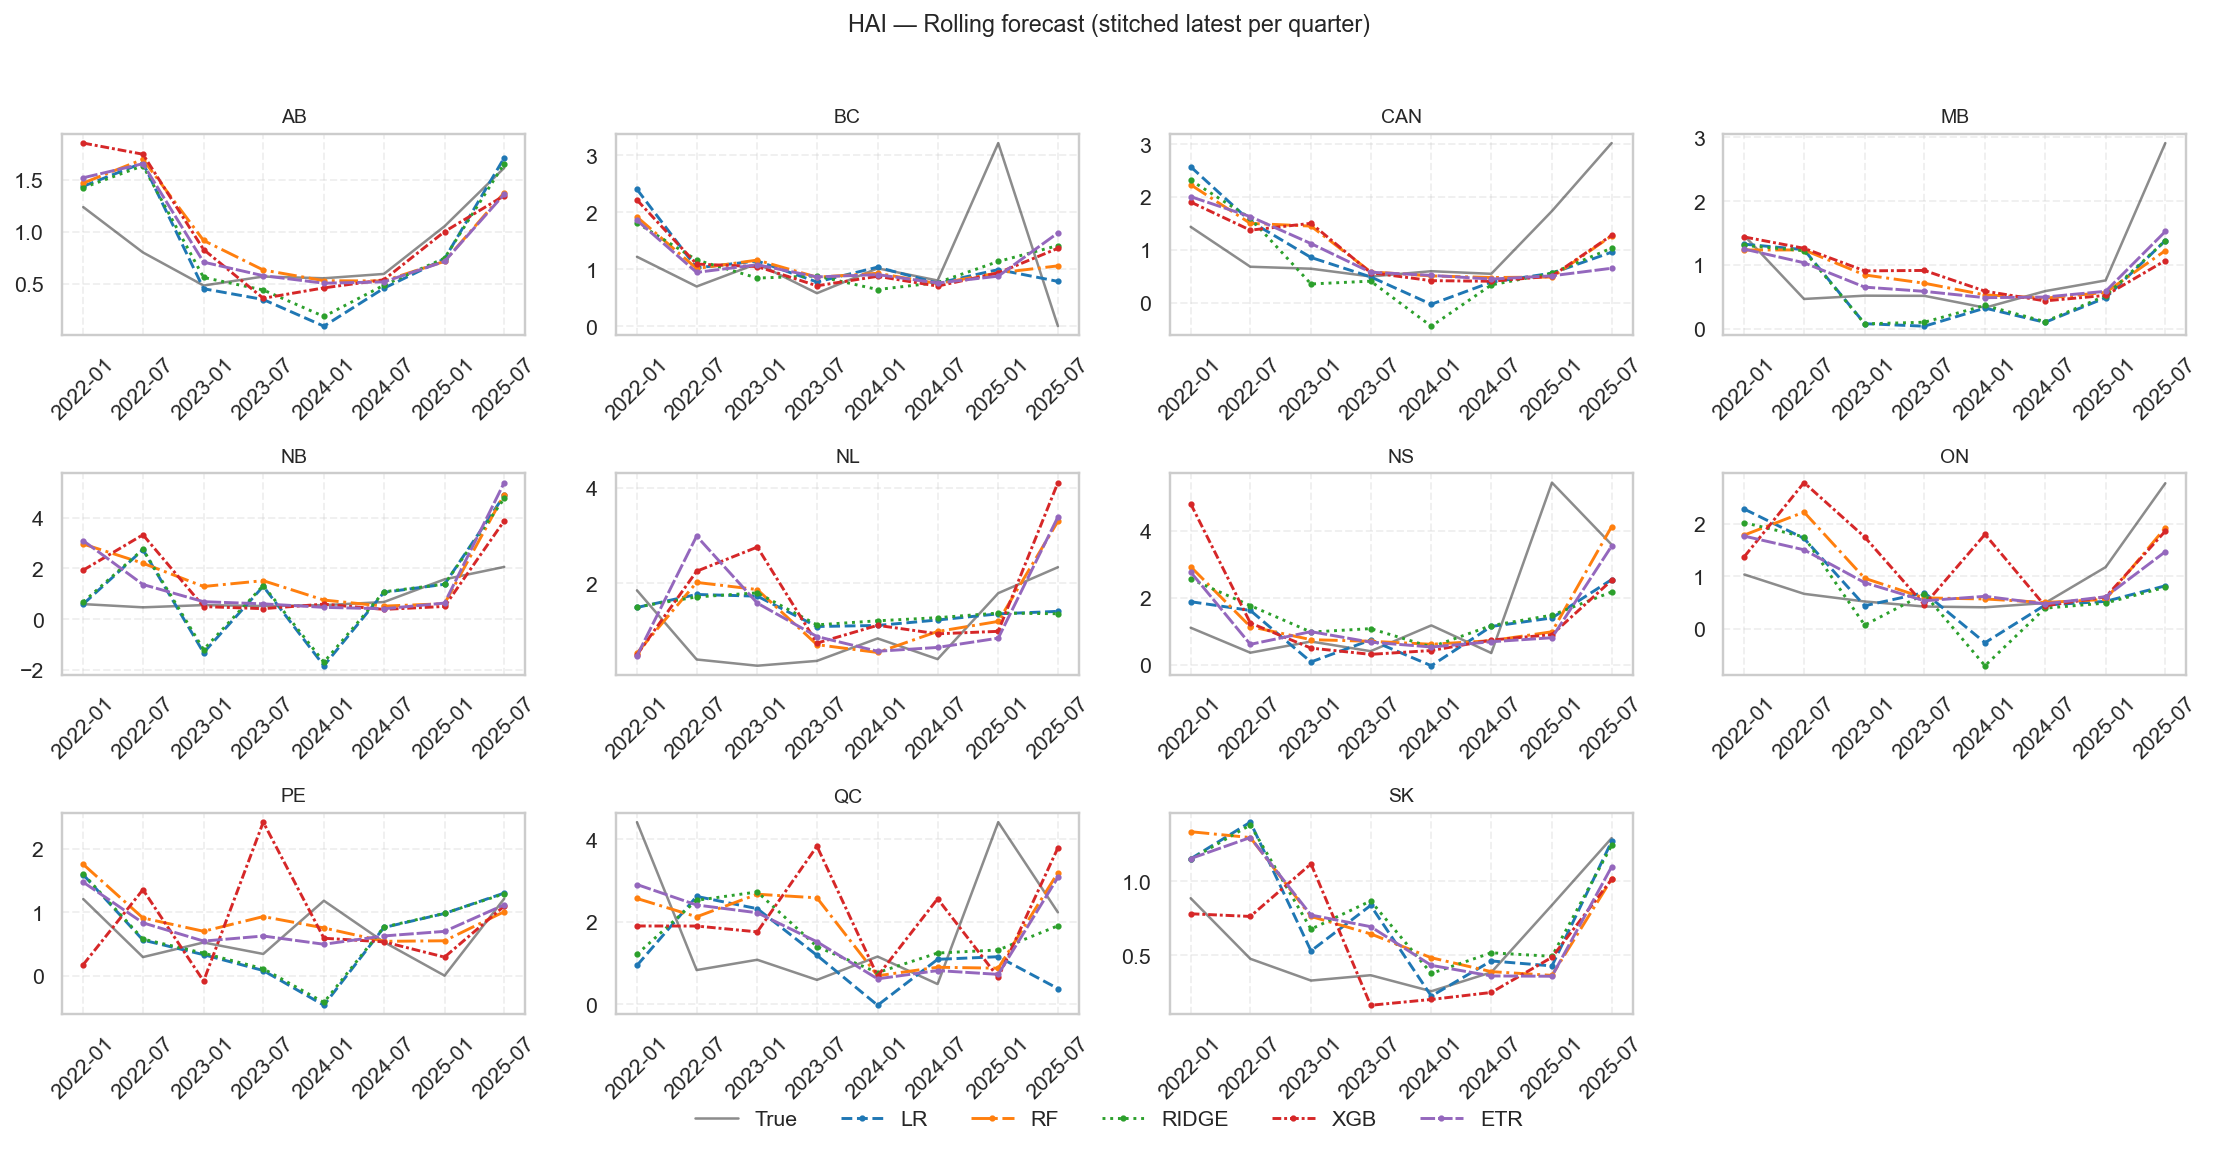


=== Heatmaps & Rankings (Holdout) ===


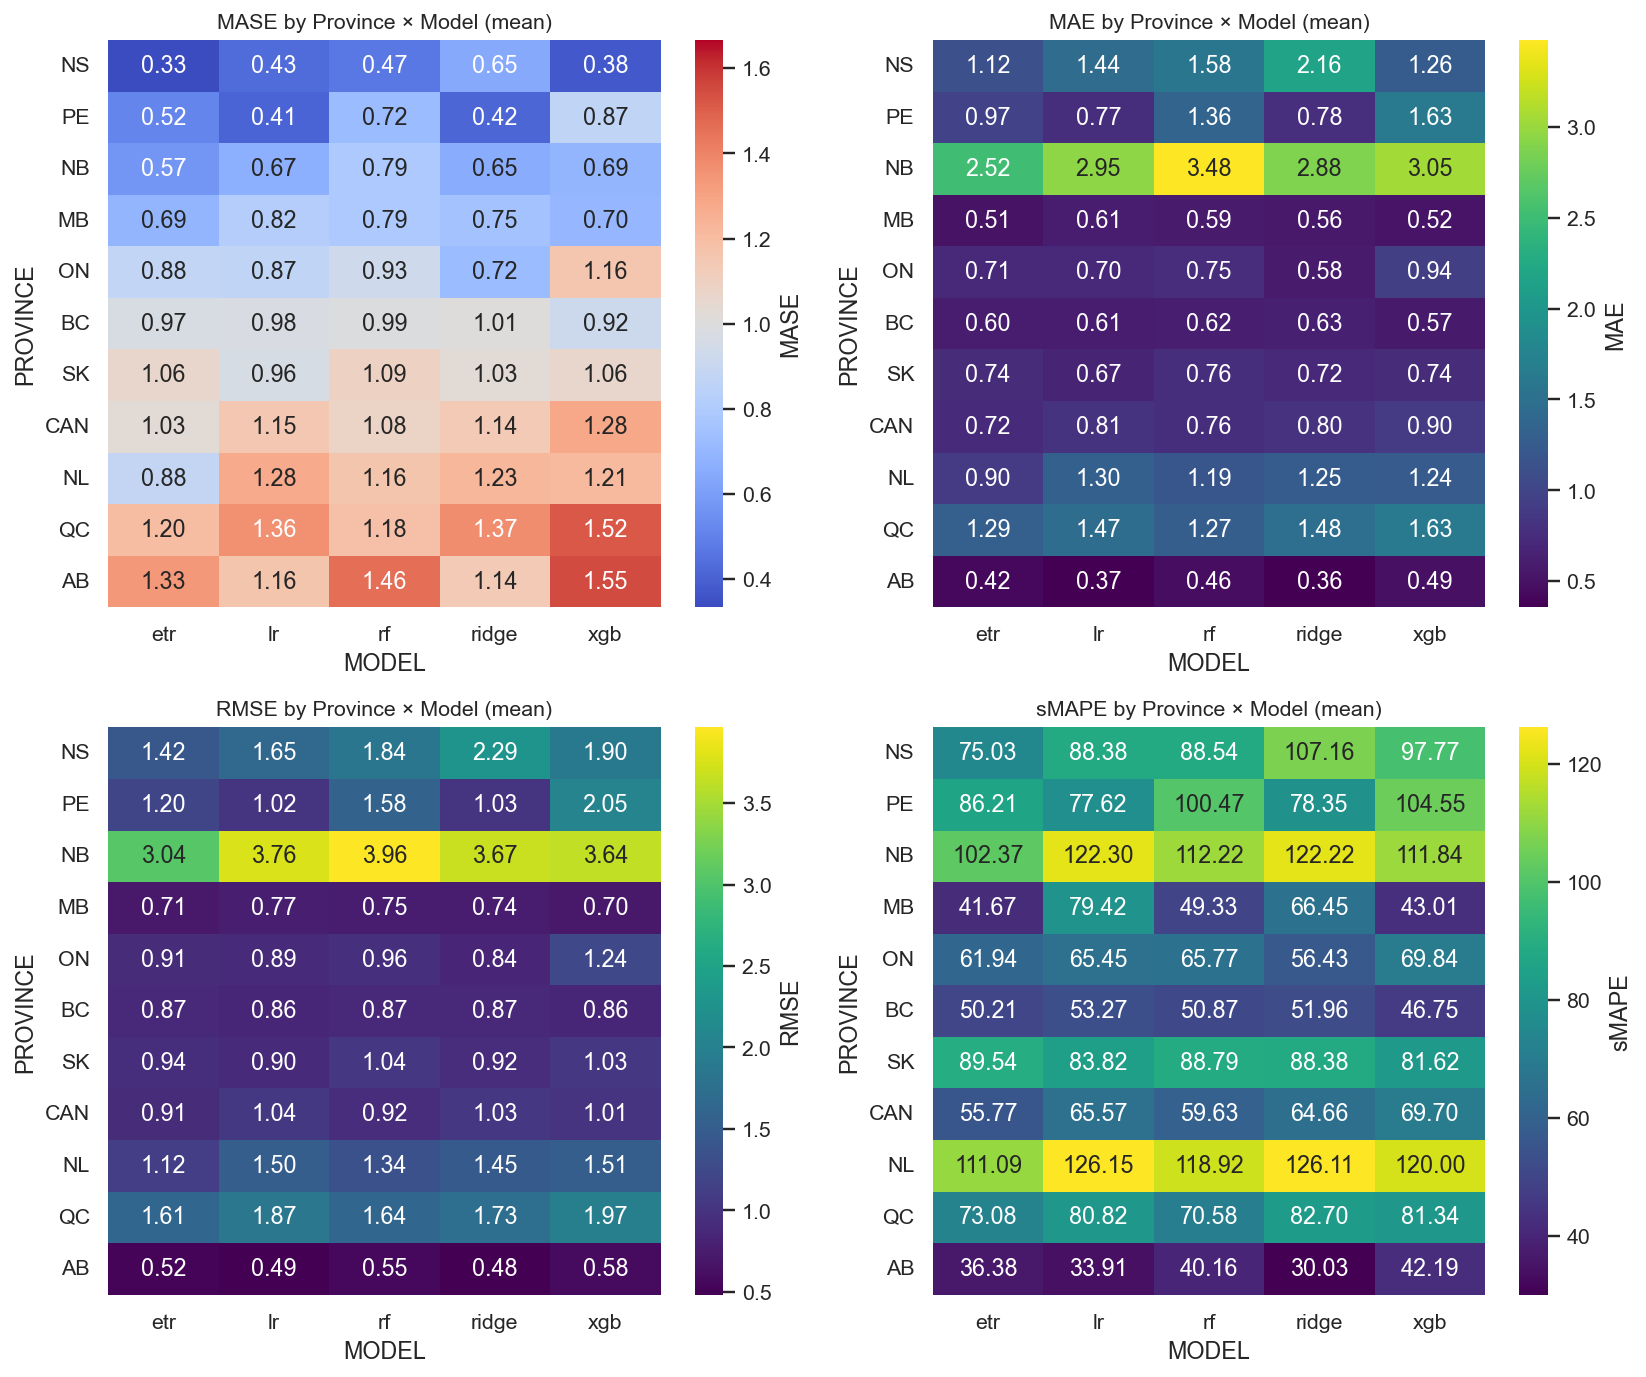

Leaderboard (holdout by MASE):


model  wins  avg_rank  med_rank  mean_metric  n_provinces
0    ETR     5  1.909091       2.0     0.860257           11
1     LR     2  2.909091       3.0     0.917603           11
2  RIDGE     2  2.909091       3.0     0.918194           11
3     RF     1  3.545455       4.0     0.970542           11
4    XGB     1  3.727273       4.0     1.030649           11


=== Heatmaps & Rankings (Rolling) ===


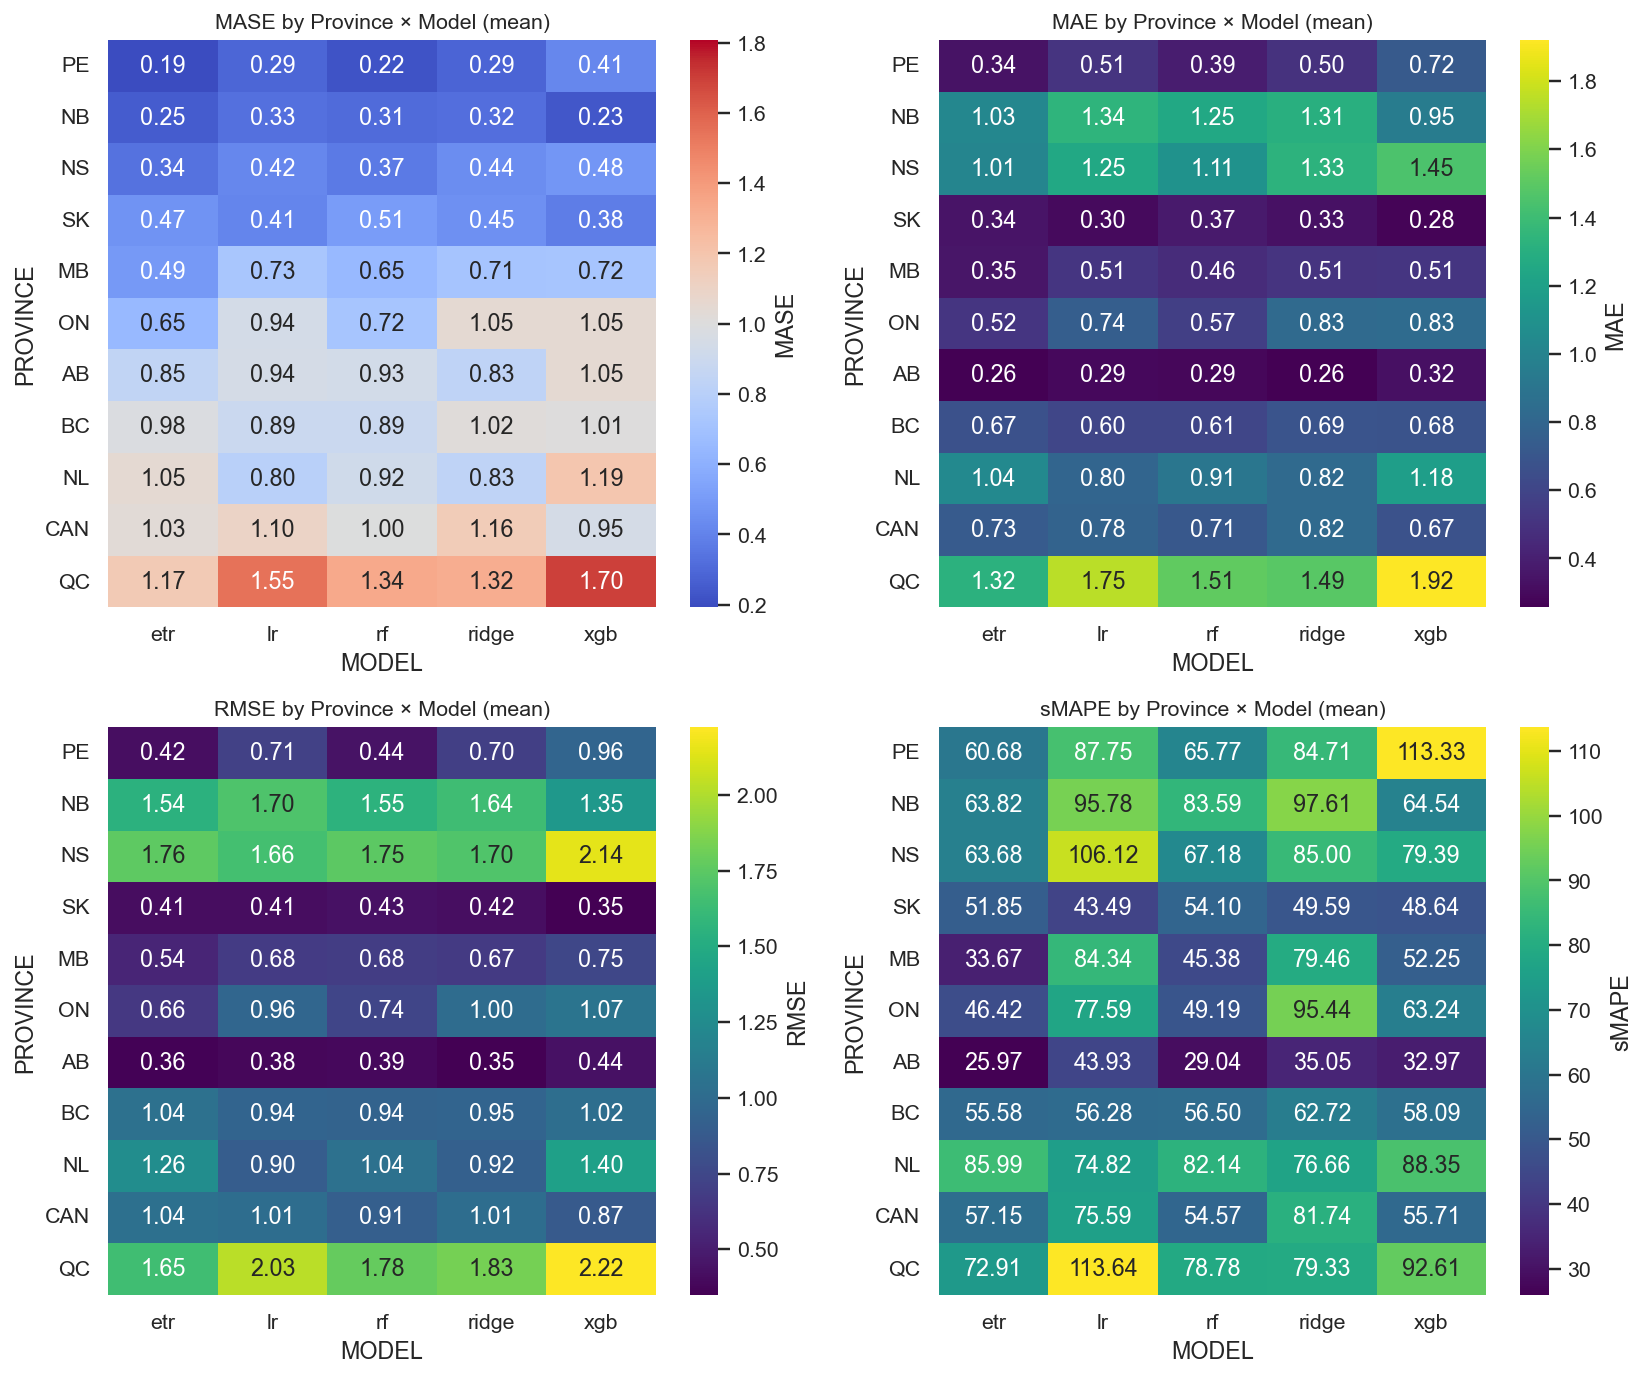

Leaderboard (rolling by MASE):


model  wins  avg_rank  med_rank  mean_metric  n_provinces
0    ETR     5  2.090909       2.0     0.680951           11
1    XGB     3  3.636364       4.0     0.834174           11
2     LR     2  3.272727       4.0     0.765175           11
3  RIDGE     1  3.363636       3.0     0.767677           11
4     RF     0  2.636364       2.0     0.714856           11

In [29]:

# (A) RAW input: no smooth features, predict raw target
res_raw = run_hai_experiment(
    prediction_choice=H_RUN,
    smooth_window=4,
    smooth_func="median",
    use_smooth_features=False,
    predict_smooth_target=False,
    models=ALL_MODELS,
    cutoff=CUTOFF_DATE,
    initial_roll="2012-12-31",
    roll_fh=None,         # None -> uses H
    roll_step=2,
    roll_last_k=8,
    n_iter_tune=8
)


<large>
<b>Experiment B — SMOOTHED Input</b>

Apply median smoothing with window=4 to both features and the target, then forecast the smoothed target.  
This can mitigate outliers and denominator-driven spikes in HAI at the cost of lag.
We keep all other settings identical to the RAW run for a fair comparison.
</large>


In [30]:

# (B) SMOOTHED input: smooth features + predict smoothed target
res_smooth = run_hai_experiment(
    prediction_choice=H_RUN,
    smooth_window=4,
    smooth_func="median",
    use_smooth_features=True,
    predict_smooth_target=True,
    models=ALL_MODELS,
    cutoff=CUTOFF_DATE,
    initial_roll="2012-12-31",
    roll_fh=None,         # None -> uses H
    roll_step=2,
    roll_last_k=8,
    n_iter_tune=8
)



=== CONFIG ===
Mode=next_quarter | H=1 | season=1
Smooth: window=4, func=median, featS=True, targetSm=True
Features: ['hai_raw_lag1', 'hai_raw_lag4', 'dwelling_starts_lag1', 'pop_change_q_lag1', 'needed_units_q_lag1', 'hai_roll_lag1', 'hai_roll_lag4']
Holdout: Train 1991-01-01 → 2018-10-01 | Test 2019-01-01 → 2025-07-01
⏳ Running tuning from scratch...
🧮 Tuning: 11 prov × 5 models × 8 trials (fh=1, season=1)
→ [1/55] AB — LR ... best MASE=1.390
→ [2/55] AB — RF ... 

KeyboardInterrupt: 

<large>
<b>Cache Paths</b>

Each run reports the path to its cached best-params bundle.  
Use these caches to reproduce results quickly or to run inference without re-tuning.
</large>


In [ ]:

print("\nCache (RAW):    ", res_raw["cache_path"])
print("Cache (SMOOTH): ", res_smooth["cache_path"])
